In [1]:
import numpy as np
import h5py
# import tables
import scipy.io
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Order of channels as defined in JRClust spike sorting
siteMap = [21, 22, 42, 19, 41, 20, 44, 17, 43, 24, 46, 23, 45, 26, 39, 25, 40, 28, 37, 27, 38, 30, 35, 29, 36, 32, 33, 18, 34, 16, 31, 15, 47, 14, 48, 13, 50, 12, 49, 11, 52, 10, 51, 9, 54, 8, 53, 7, 56, 6, 55, 5, 58, 4, 57, 3, 60, 2, 59, 1, 62, 64, 61, 63, 88, 85, 105, 86, 108, 83, 107, 84, 110, 81, 109, 87, 106, 90, 103, 89, 104, 92, 101, 91, 102, 94, 99, 93, 100, 96, 97, 95, 98, 82, 111, 80, 112, 79, 114, 78, 113, 77, 116, 76, 115, 75, 118, 74, 117, 73, 120, 72, 119, 71, 122, 70, 121, 69, 124, 68, 123, 67, 126, 66, 125, 65, 127, 128]

In [3]:
def spikesByCluster(path):
    """Returns a dictionary of each spike cluster with timestamps and recording site id"""
    spikesByCluster={}
    with h5py.File(path, 'r') as f:
        print(f.keys())
        sTimes=np.array(f['spikeTimes']).flatten()
        for  idx,ref in  enumerate(np.reshape(np.array(f['spikesByCluster']),-1)):
            cluster="Cluster"+str(idx)
            spikesByCluster[idx]={}
            #Spike timestamps for given cluster
            spikesByCluster[idx]["spikes"]=sTimes[np.reshape(np.array(f[ref])-1, -1).astype('int')]
            #The recording site (Intan#ID) id for given cluster
            spikesByCluster[idx]["site"]=np.array(f["clusterSites"]).flatten()[idx]-1

    return spikesByCluster

In [4]:
def swrResponse(spikesByCluster, swr_centers, win=1, num_bins=20, fs=2e4):
    """Returns an array (n_clusters, n_swr, num_bins) of histograms,
    each row is the firing count of given cluster around the given swr event"""
    for cluster in spikesByCluster:
        spikes_arr=spikesByCluster[cluster]['spikes']

        for swr_id, swr in enumerate(swr_centers):
            rng_min=swr-(win*fs)/2
            rng_max=swr+(win*fs)/2
            hist, bin_edges=np.histogram(spikes_arr, num_bins, range=(rng_min, rng_max), density=False)
            binned_spikes[cluster,swr_id,:]=hist
            
    return hist

## Session 9

In [5]:
spikesByCluster={}
with h5py.File('./data/rEO_06/9_240229_163045/amplifier_res.mat', 'r') as f:
# f=h5py.File('./data/rEO_06/9_240229_163045/amplifier_res.mat', 'r')
    print(f.keys())
    sTimes=np.array(f['spikeTimes']).flatten()
    for  idx,ref in  enumerate(np.reshape(np.array(f['spikesByCluster']),-1)):
        cluster="Cluster"+str(idx)
        spikesByCluster[idx]={}
        spikesByCluster[idx]["spikes"]=sTimes[np.reshape(np.array(f[ref])-1, -1).astype('int')]
        spikesByCluster[idx]["site"]=np.array(f["clusterSites"]).flatten()[idx]-1

spikesByCluster_ses9=spikesByCluster
#     print(np.array(f['spikeTimes']))

<KeysViewHDF5 ['#refs#', '#subsystem#', 'annotatedOnly', 'centerSites', 'clusterCenters', 'clusterCentroids', 'clusterNotes', 'clusterSites', 'curatedOn', 'detectTime', 'detectedOn', 'editPos', 'featuresShape', 'filtShape', 'history', 'initialClustering', 'meanSiteThresh', 'meanWfGlobal', 'meanWfGlobalRaw', 'meanWfLocal', 'meanWfLocalRaw', 'meanWfRawHigh', 'meanWfRawLow', 'nSitesOverThresh', 'nSpikes', 'ordRho', 'rawShape', 'rhoCutGlobal', 'rhoCutSite', 'rhoCuts', 'siteRMS', 'siteThresh', 'sortTime', 'sortedOn', 'spikeAmps', 'spikeClusters', 'spikeDelta', 'spikeNeigh', 'spikePositions', 'spikeRho', 'spikeSites', 'spikeSites2', 'spikeSites3', 'spikeTimes', 'spikesByCluster', 'spikesBySite', 'spikesBySite2', 'spikesBySite3', 'unitCount', 'unitISIRatio', 'unitIsoDist', 'unitLRatio', 'unitPeakSites', 'unitPeaks', 'unitPeaksRaw', 'unitSNR', 'unitVpp', 'unitVppRaw', 'waveformSim']>


In [6]:
fs=2e4      # Sampling frequency
# Detected SWR
f=scipy.io.loadmat('./data/rEO_06/9_240229_163045/curated_ripples.mat')
print(f.keys())

# Only using from right-hemisphere
right_swr=f['ripple_timestamps'][f['ripple_classes'].flatten()=="right"]
# Finding the center points
swr_centers=np.round(np.mean((right_swr*fs), axis=1)).astype('int')

# f.clear()

dict_keys(['__header__', '__version__', '__globals__', 'ripple_timestamps', 'ripple_classes'])


In [7]:
num_bins=20
binned_spikes =np.zeros((len(spikesByCluster), len(swr_centers), num_bins))
bins=np.linspace(0,1,num_bins)

In [8]:
# window length in seconds
win=1
for cluster in spikesByCluster:
    spikes_arr=spikesByCluster[cluster]['spikes']
    
    for swr_id, swr in enumerate(swr_centers):
        rng_min=swr-(win*fs)/2
        rng_max=swr+(win*fs)/2
        hist, bin_edges=np.histogram(spikes_arr, num_bins, range=(rng_min, rng_max), density=False)
        binned_spikes[cluster,swr_id,:]=hist
        
mean_hist_ses9=np.mean(binned_spikes, axis=1)
standardized_hist_ses9=np.divide((mean_hist_ses9-np.mean(mean_hist_ses9, axis=0)),np.std(mean_hist_ses9, axis=0))

In [12]:
np.std(standardized_hist_ses9, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

/var/folders/cy/wg7pd_p11rg7b4s4wwvgdnvr0000gn/T/ipykernel_62546/2626413397.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


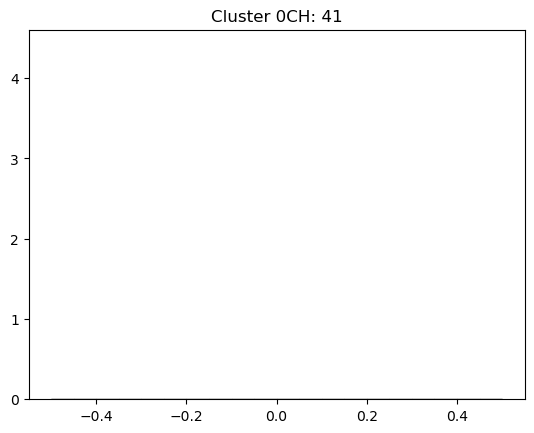

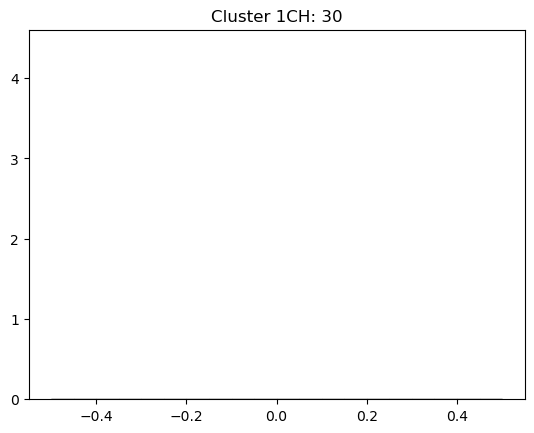

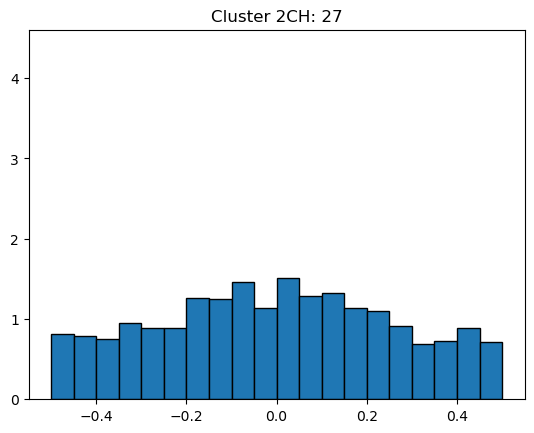

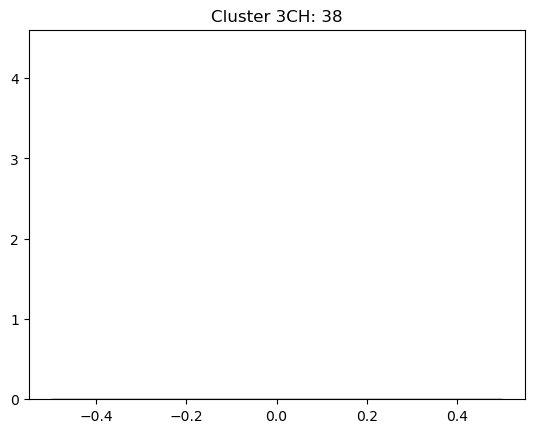

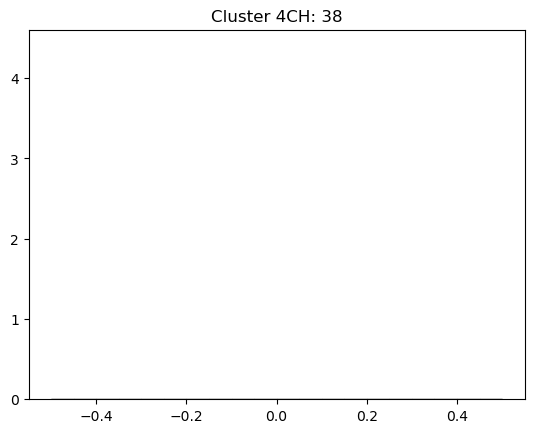

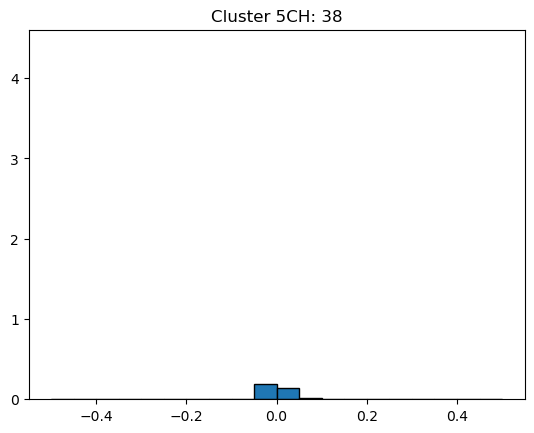

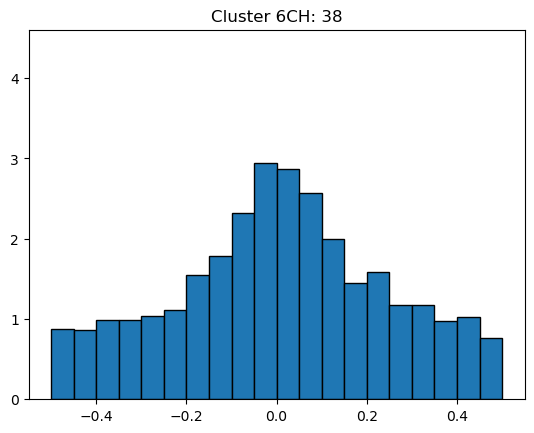

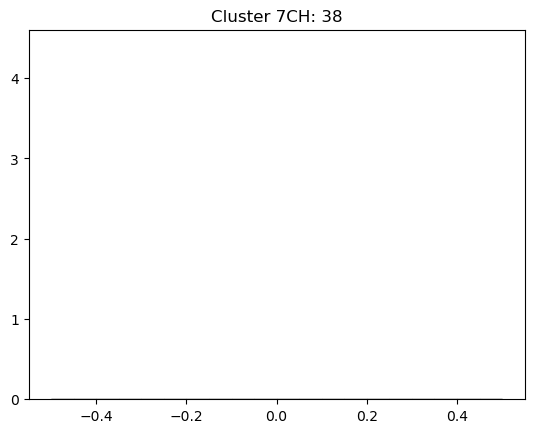

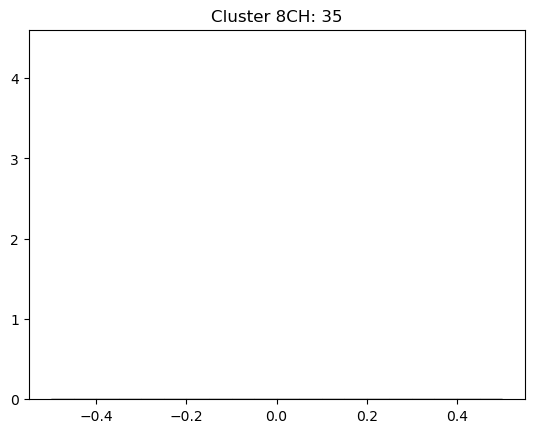

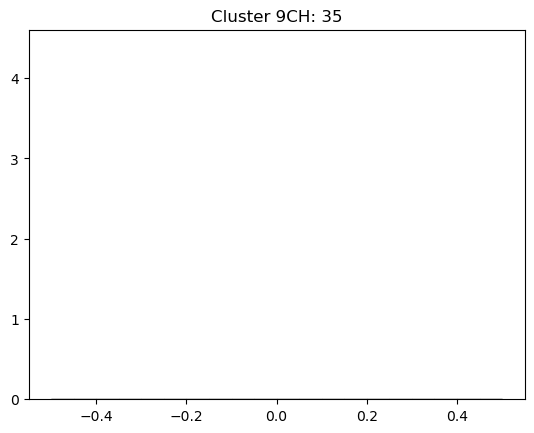

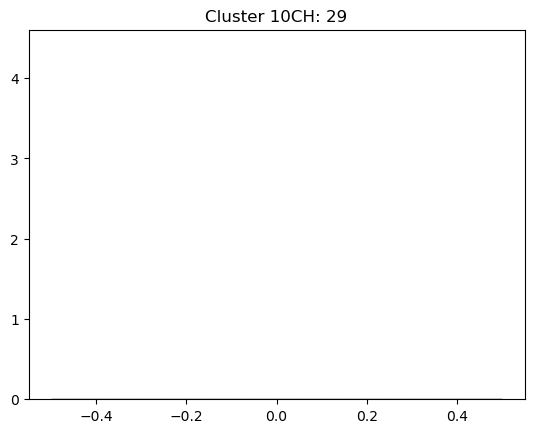

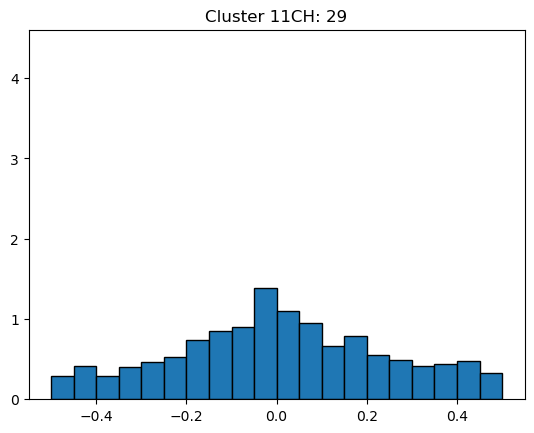

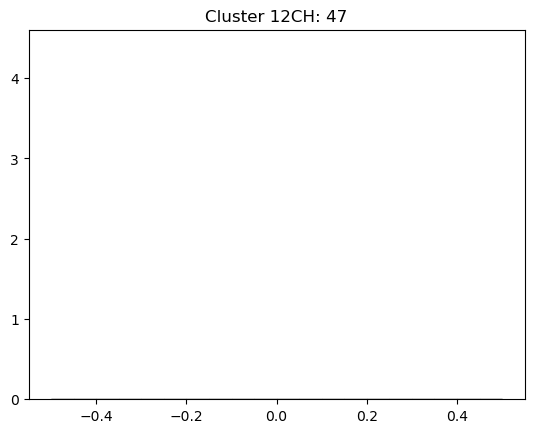

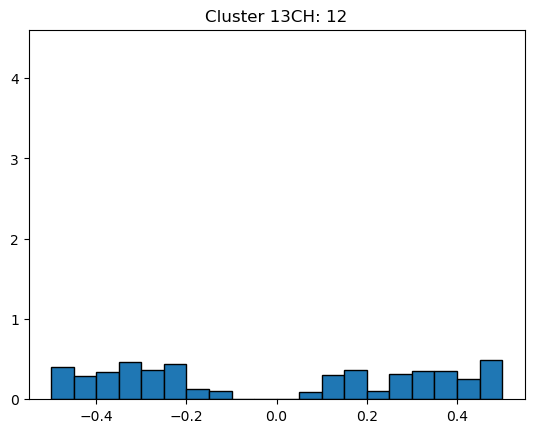

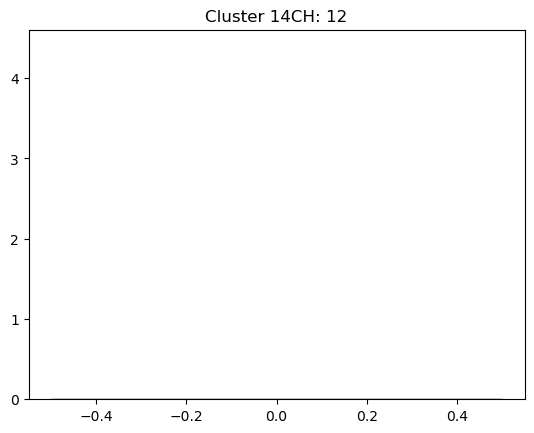

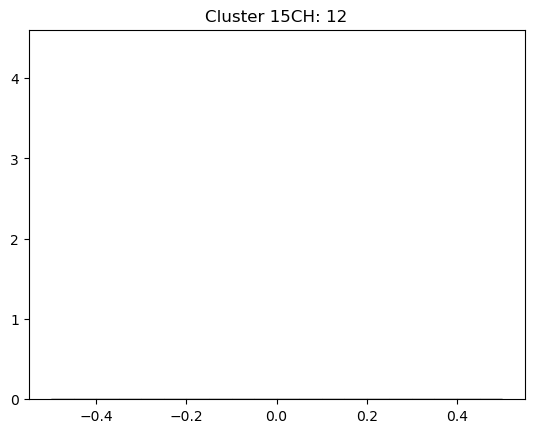

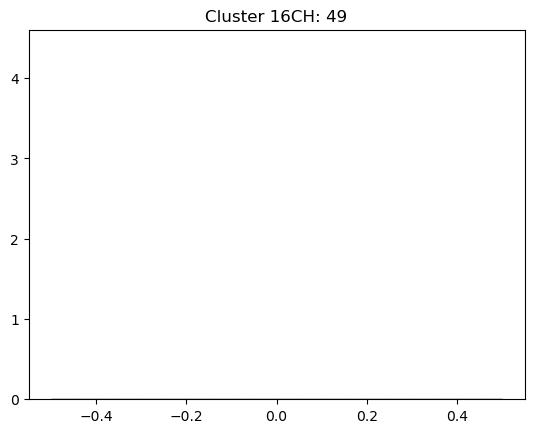

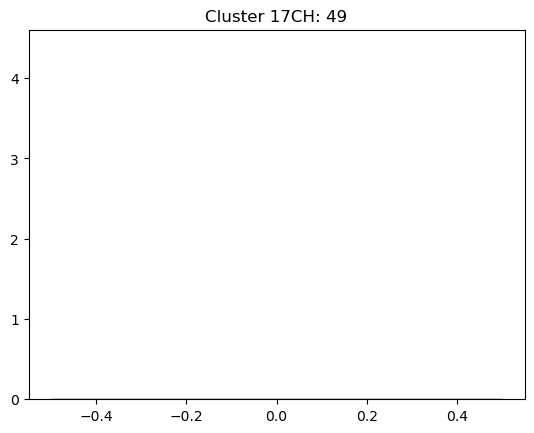

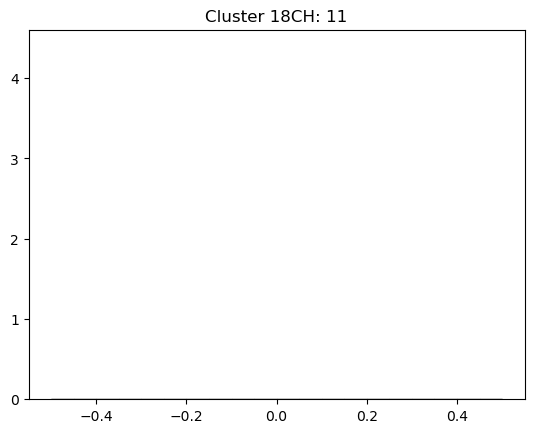

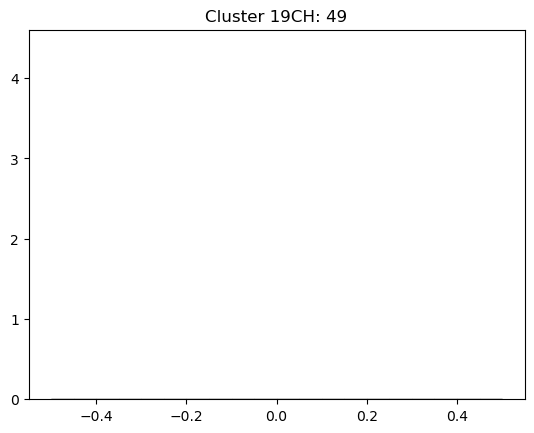

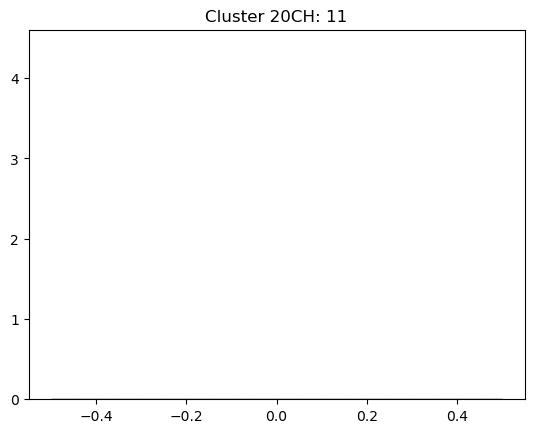

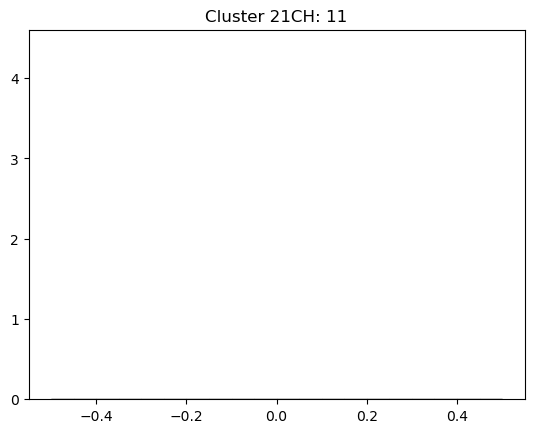

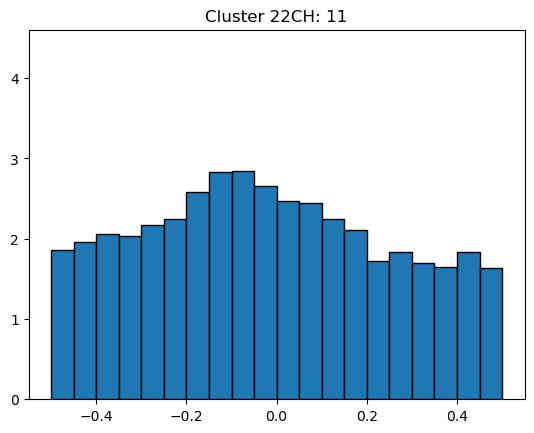

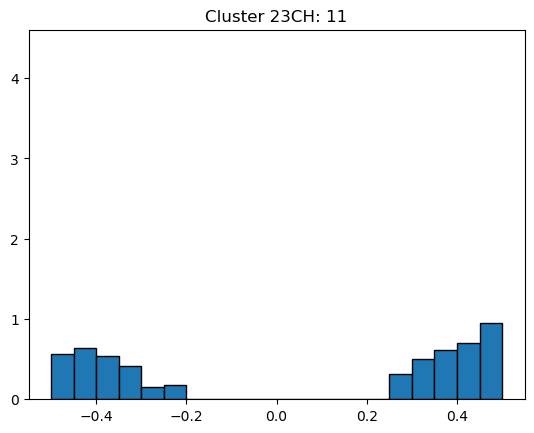

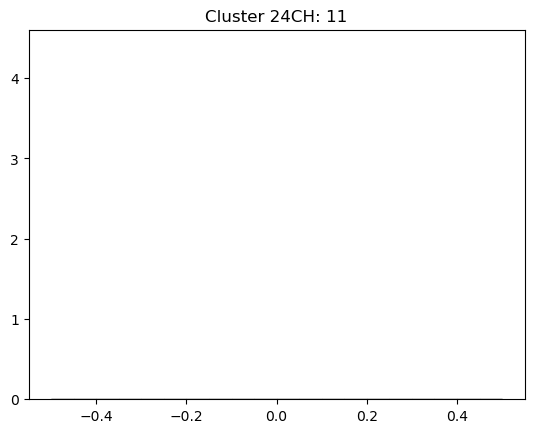

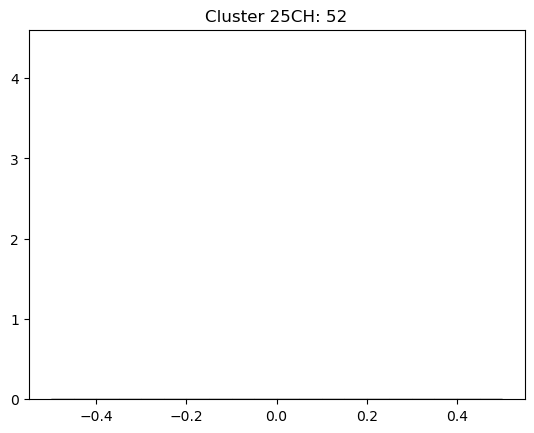

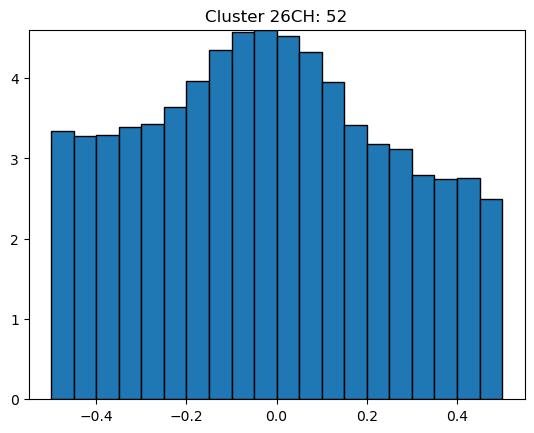

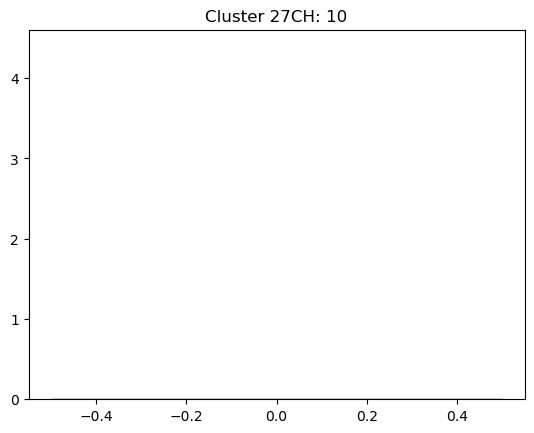

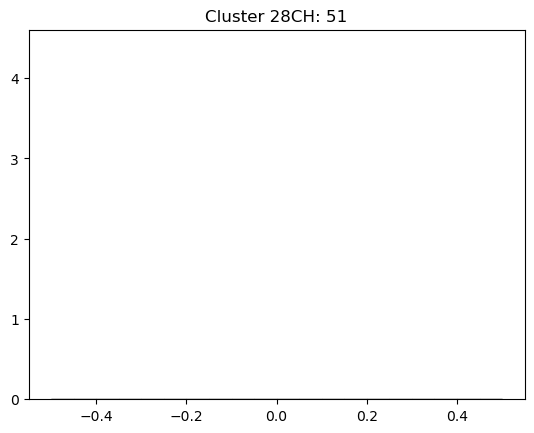

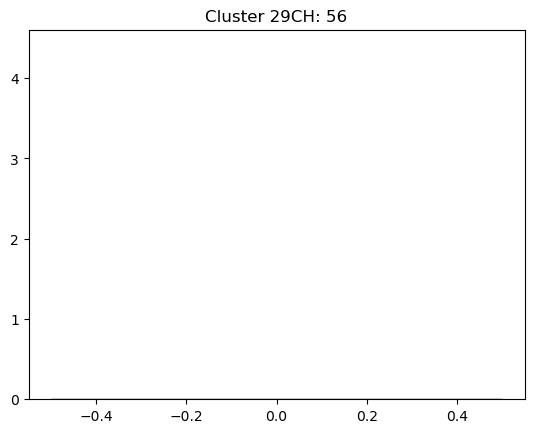

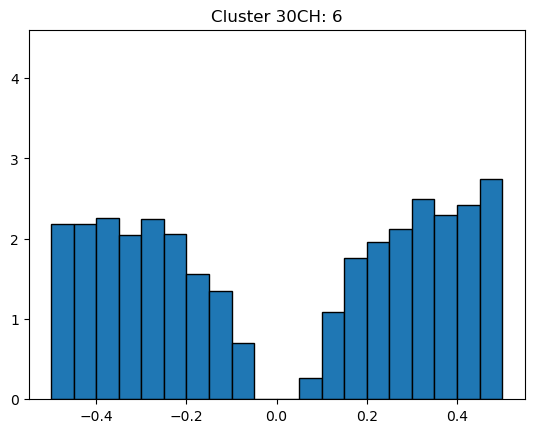

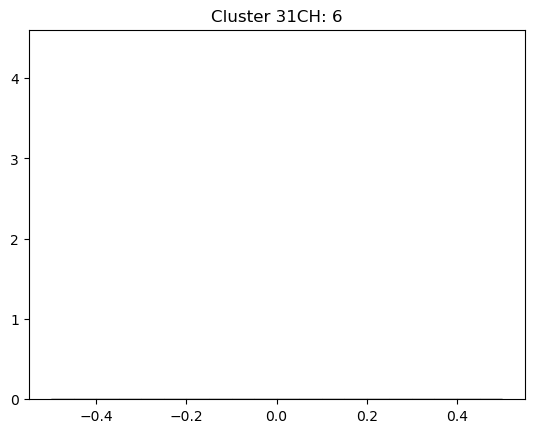

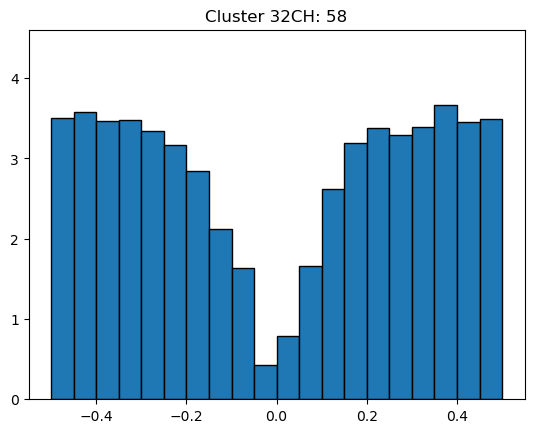

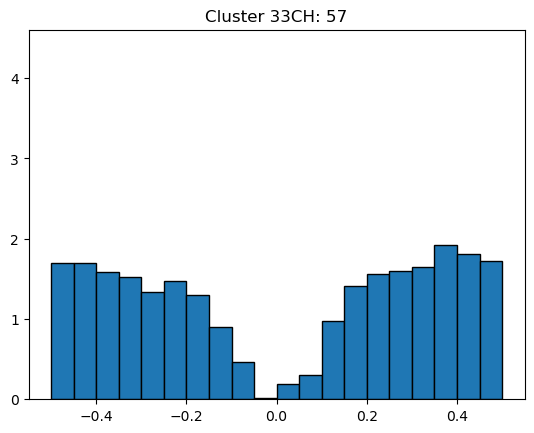

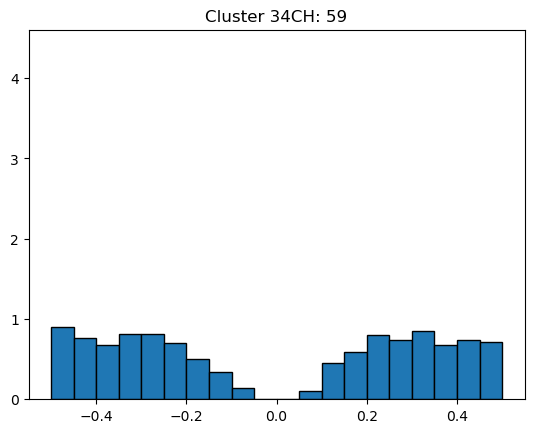

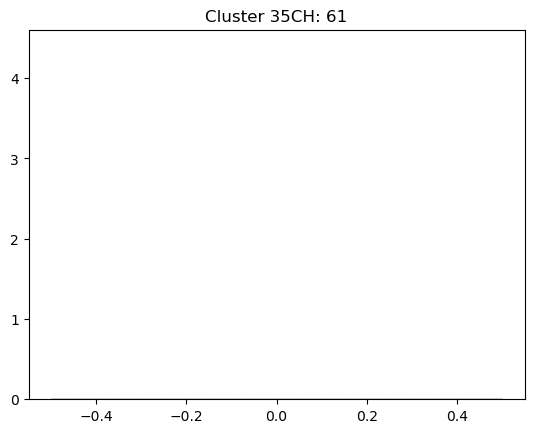

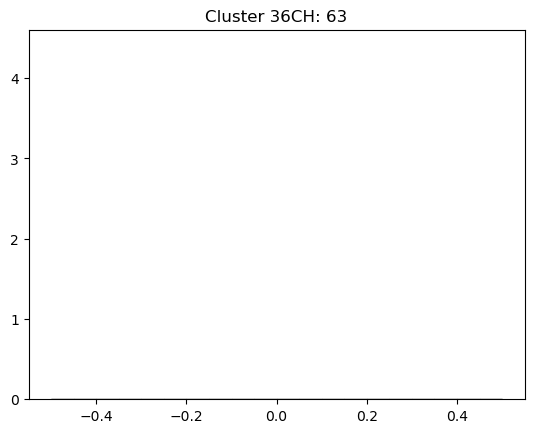

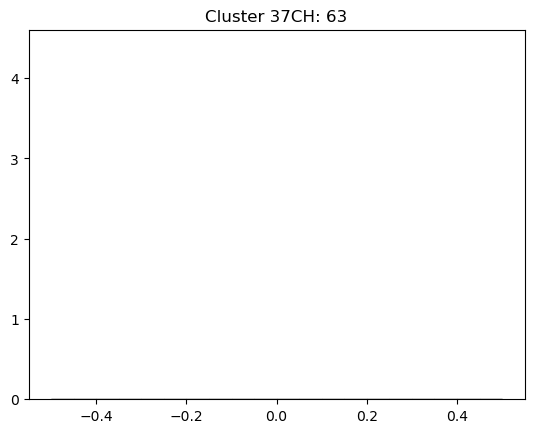

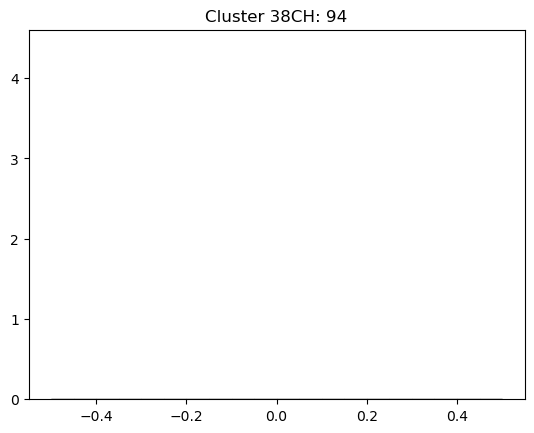

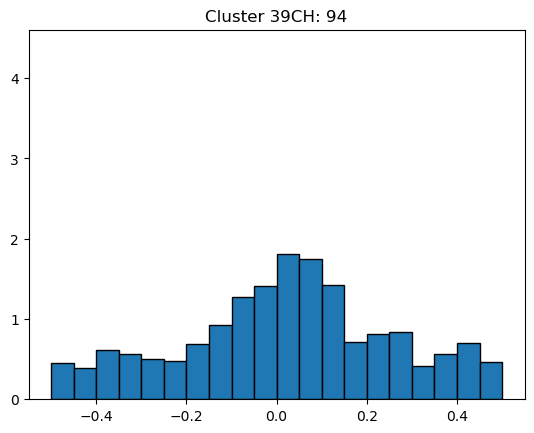

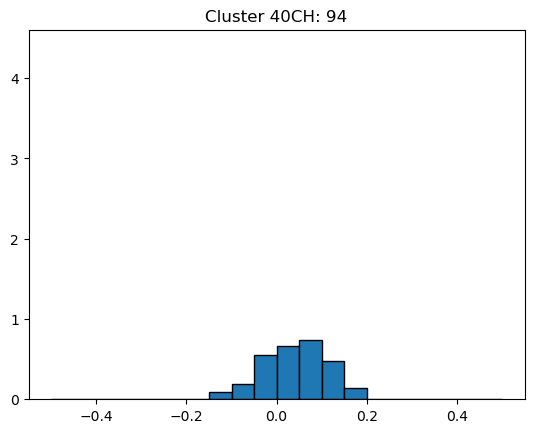

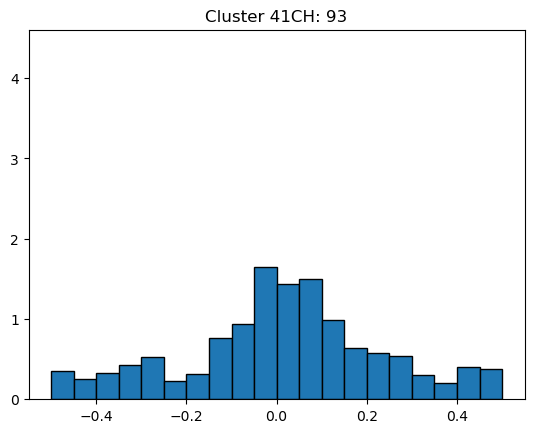

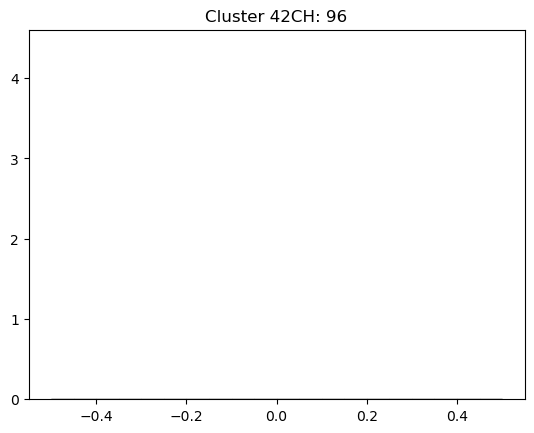

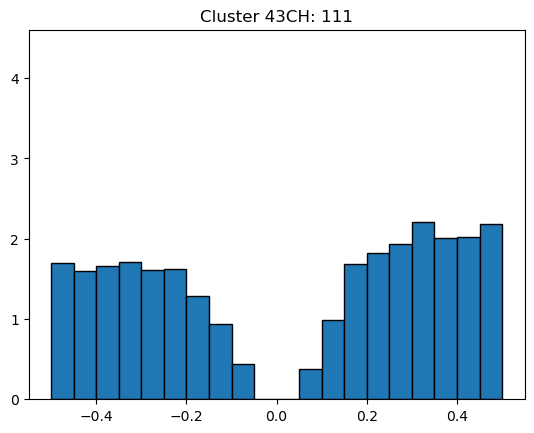

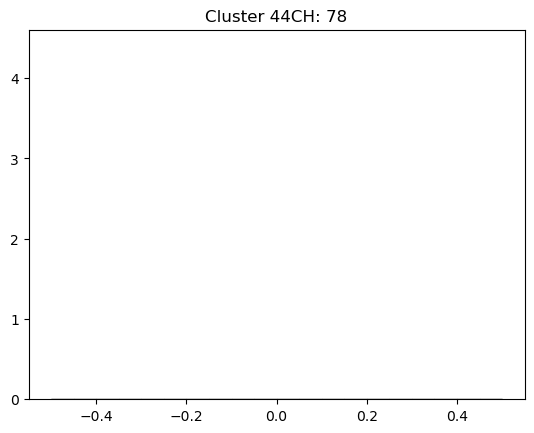

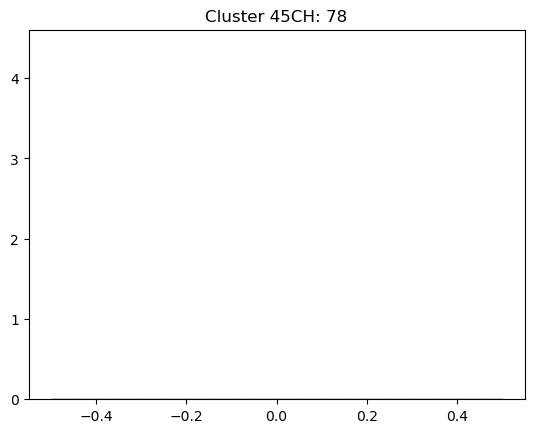

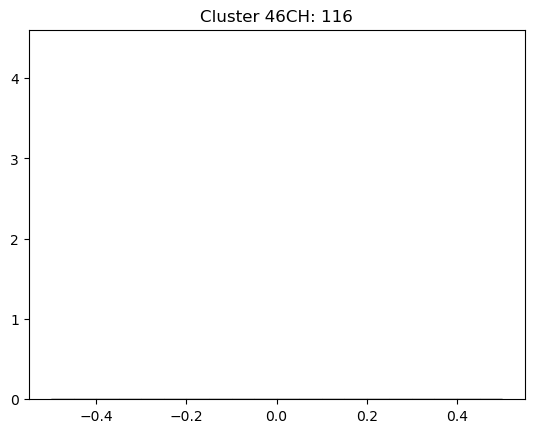

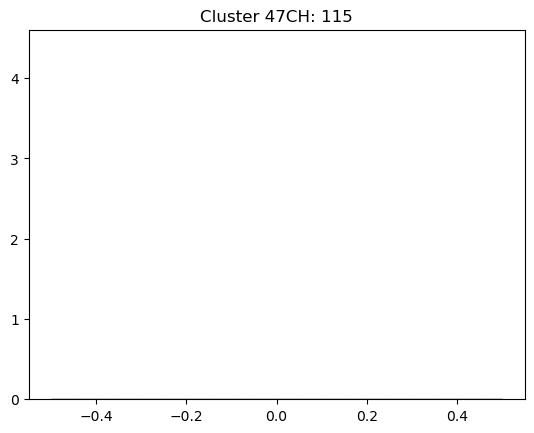

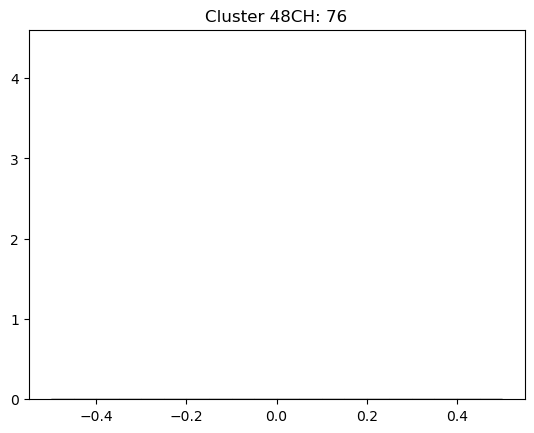

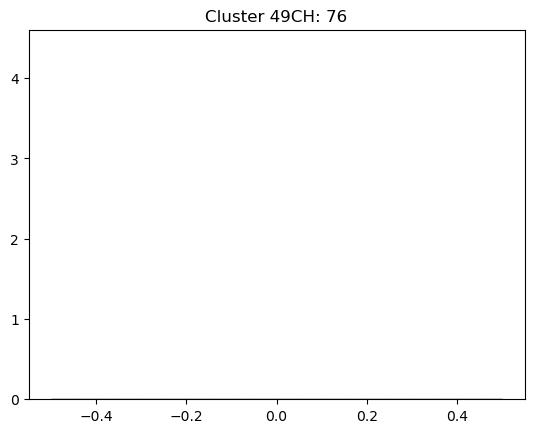

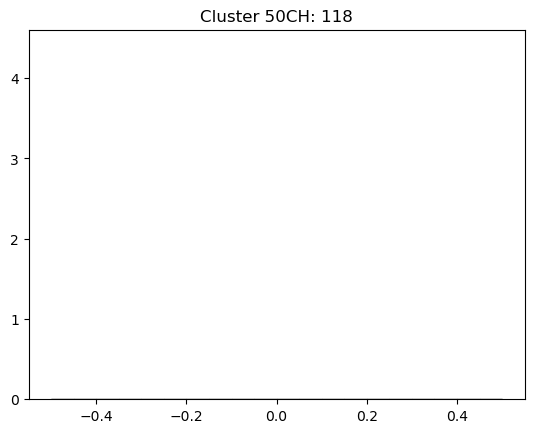

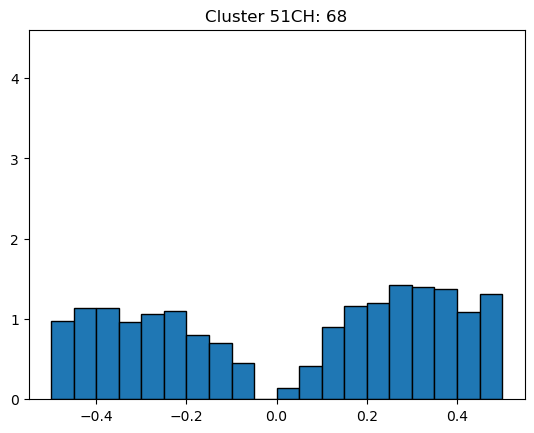

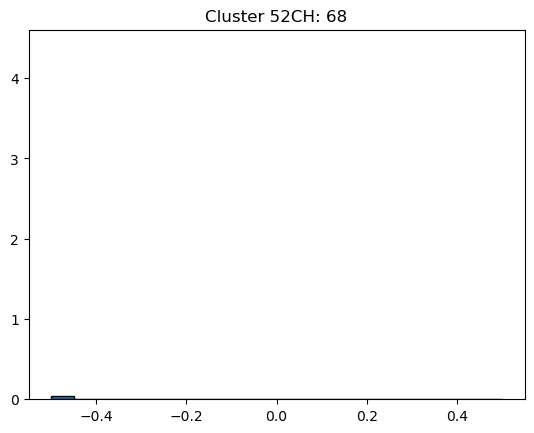

In [13]:
bins=np.linspace(-1*(win/2),1*(win/2),num_bins+1)
for cls, h in enumerate(standardized_hist_ses9):
    plt.figure()
    plt.ylim([0,np.max(standardized_hist_ses9)])
    plt.bar(bins[:-1], h, width=np.diff(bins), edgecolor="black", align="edge")
    plt.title("Cluster "+str(cls)+"CH: "+str(siteMap[int(spikesByCluster[cls]["site"])]))

## Session 6

In [278]:
spikesByCluster={}
with h5py.File('./data/rEO_06/6_240205_150311/amplifier_res.mat', 'r') as f:
# f=h5py.File('./data/rEO_06/9_240229_163045/amplifier_res.mat', 'r')
    print(f.keys())
    sTimes=np.array(f['spikeTimes']).flatten()
    for  idx,ref in  enumerate(np.reshape(np.array(f['spikesByCluster']),-1)):
        cluster="Cluster"+str(idx)
        spikesByCluster[idx]={}
        spikesByCluster[idx]["spikes"]=sTimes[np.reshape(np.array(f[ref])-1, -1).astype('int')]
        spikesByCluster[idx]["site"]=np.array(f["clusterSites"]).flatten()[idx]-1
        
spikesByCluster_ses6=spikesByCluster

<KeysViewHDF5 ['#refs#', '#subsystem#', 'annotatedOnly', 'centerSites', 'clusterCenters', 'clusterCentroids', 'clusterNotes', 'clusterSites', 'curatedOn', 'detectTime', 'detectedOn', 'editPos', 'featuresShape', 'filtShape', 'history', 'initialClustering', 'meanSiteThresh', 'meanWfGlobal', 'meanWfGlobalRaw', 'meanWfLocal', 'meanWfLocalRaw', 'meanWfRawHigh', 'meanWfRawLow', 'nSitesOverThresh', 'nSpikes', 'ordRho', 'rawShape', 'rhoCutGlobal', 'rhoCutSite', 'rhoCuts', 'siteRMS', 'siteThresh', 'sortTime', 'sortedOn', 'spikeAmps', 'spikeClusters', 'spikeDelta', 'spikeNeigh', 'spikePositions', 'spikeRho', 'spikeSites', 'spikeSites2', 'spikeSites3', 'spikeTimes', 'spikesByCluster', 'spikesBySite', 'spikesBySite2', 'spikesBySite3', 'unitCount', 'unitISIRatio', 'unitIsoDist', 'unitLRatio', 'unitPeakSites', 'unitPeaks', 'unitPeaksRaw', 'unitSNR', 'unitVpp', 'unitVppRaw', 'waveformSim']>


In [273]:
fs=2e4      # Sampling frequency
# Detected SWR
f=scipy.io.loadmat('./data/rEO_06/6_240205_150311/6_240205_150311-ripples.mat')
print(f.keys())

# Only using from right-hemisphere
right_swr=f['spwr'][f['labels'].flatten()=="right"]
# Finding the center points
swr_centers=np.round(np.mean((right_swr*fs), axis=1)).astype('int')


dict_keys(['__header__', '__version__', '__globals__', 'spwr', 'labels', 'threshold'])


In [274]:
binned_spikes =np.zeros((len(spikesByCluster), len(swr_centers), num_bins))
bins=np.linspace(0,1,num_bins)

In [275]:
# window length in seconds
win=1
for cluster in spikesByCluster:
    spikes_arr=spikesByCluster[cluster]['spikes']
    
    for swr_id, swr in enumerate(swr_centers):
        rng_min=swr-(win*fs)/2
        rng_max=swr+(win*fs)/2
        hist, bin_edges=np.histogram(spikes_arr, num_bins, range=(rng_min, rng_max), density=False)
        binned_spikes[cluster,swr_id,:]=hist
        
mean_hist_ses6=np.mean(binned_spikes[:38], axis=1)
standardized_hist_ses6mean_hist_ses9=np.divide((mean_hist_ses6-np.mean(mean_hist_ses6, axis=0)),np.std(mean_hist_ses6, axis=0))

/var/folders/cy/wg7pd_p11rg7b4s4wwvgdnvr0000gn/T/ipykernel_60724/1653689603.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


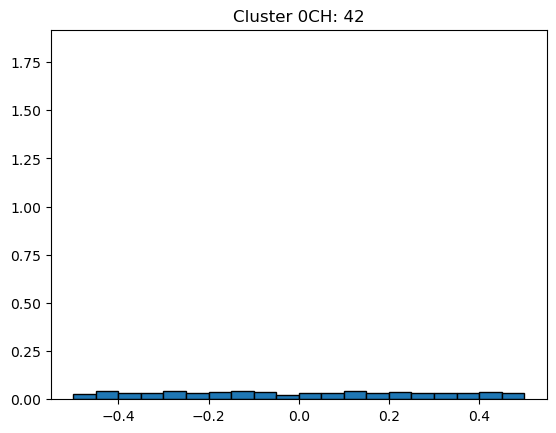

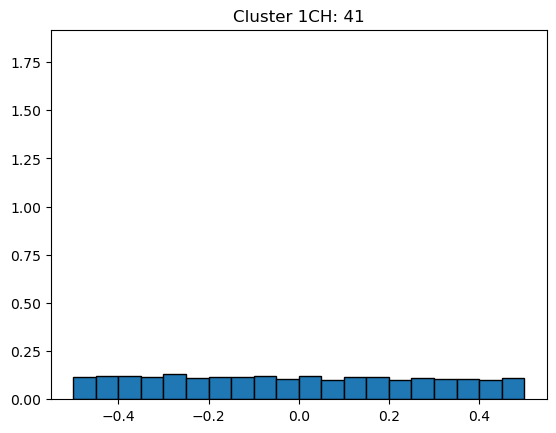

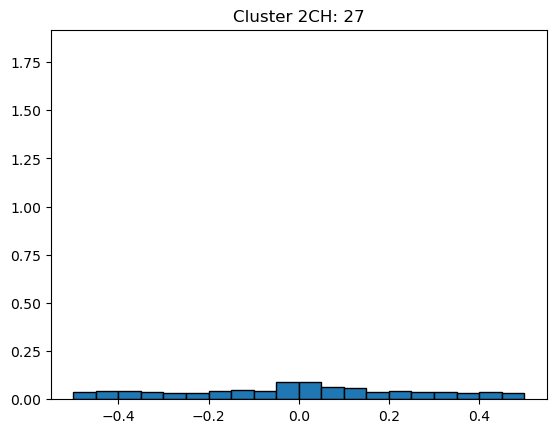

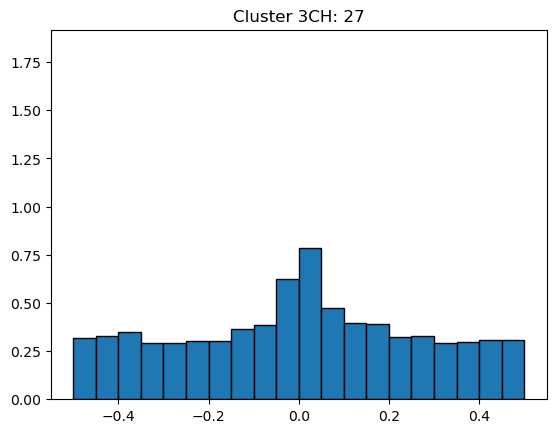

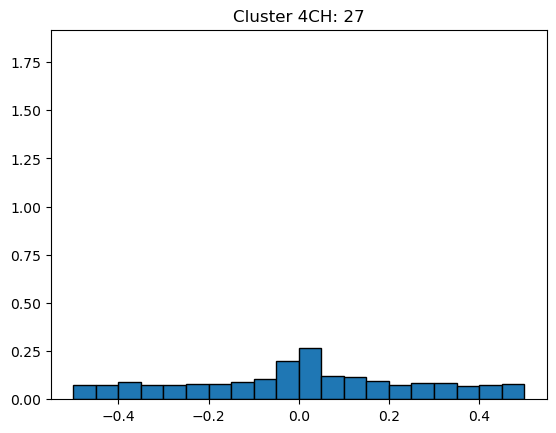

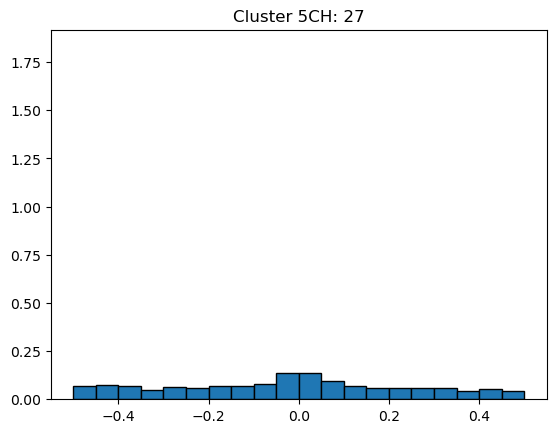

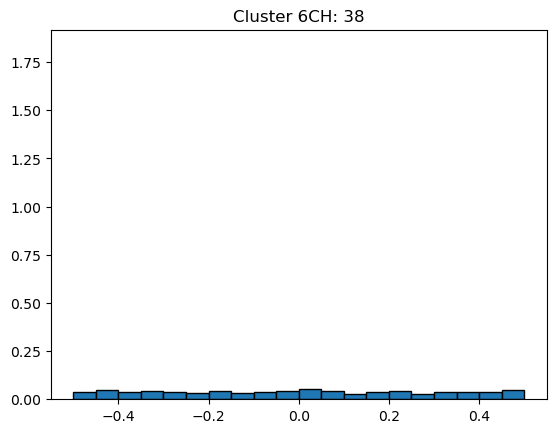

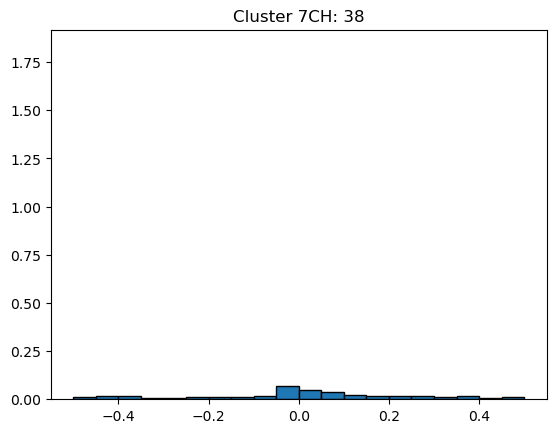

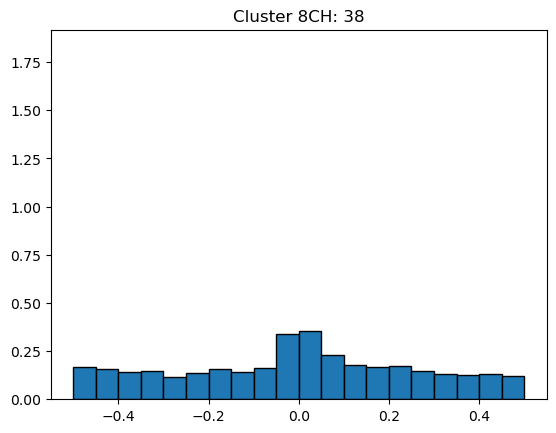

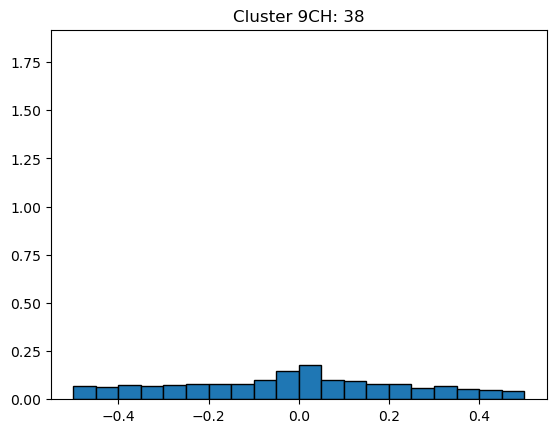

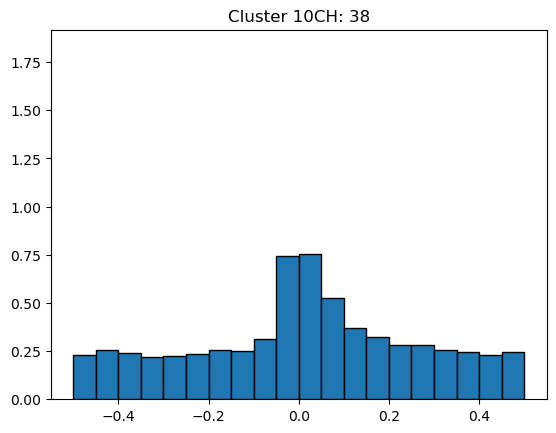

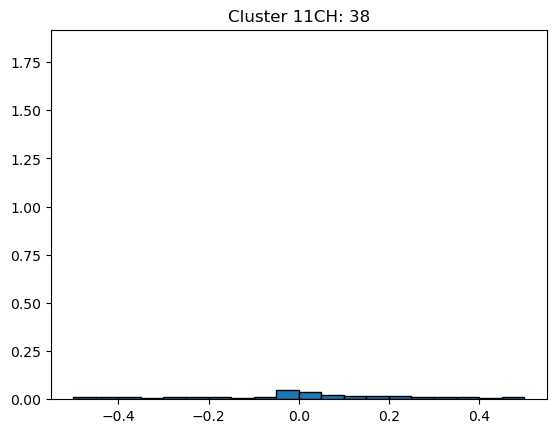

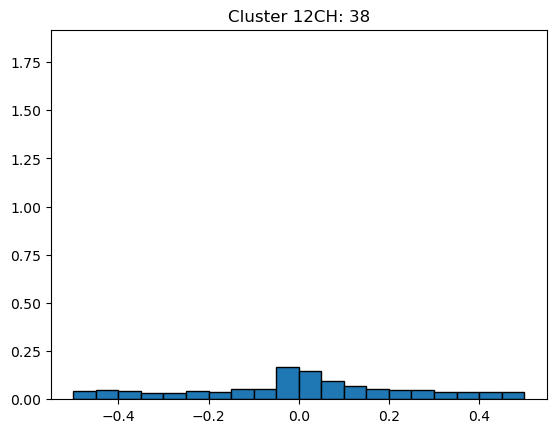

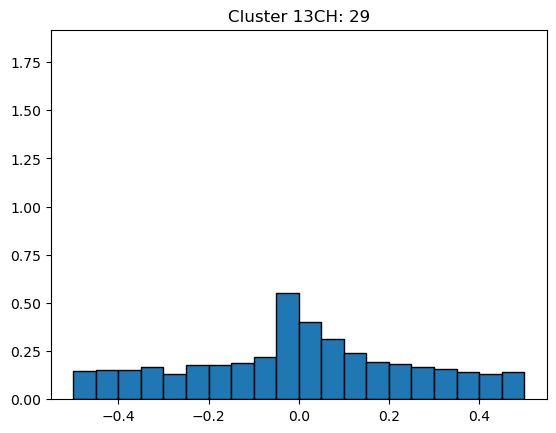

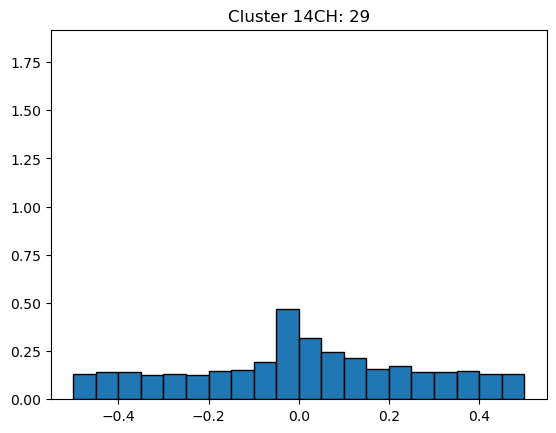

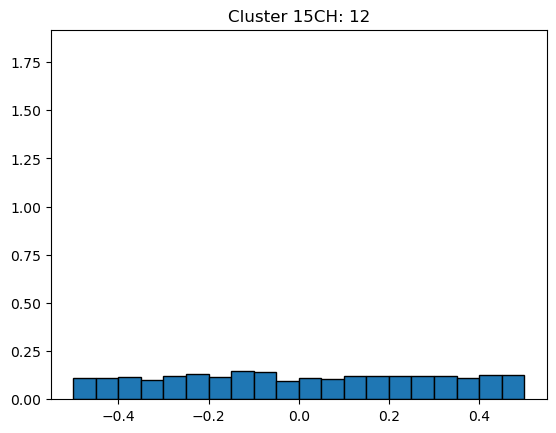

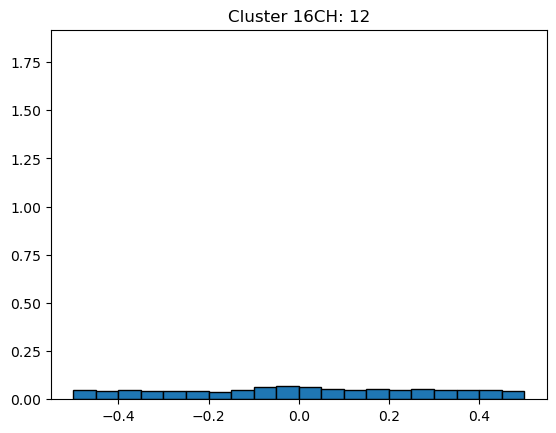

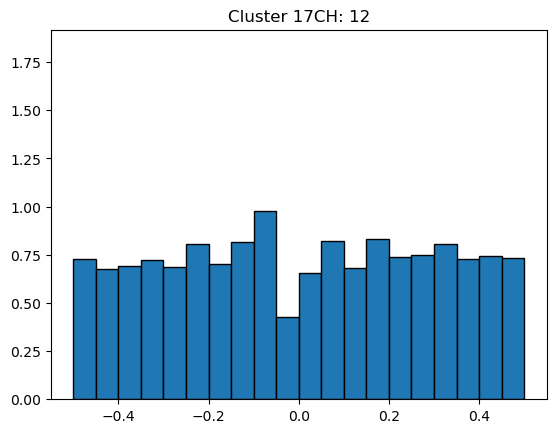

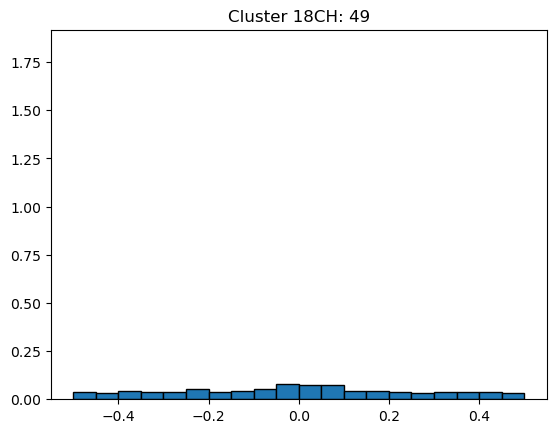

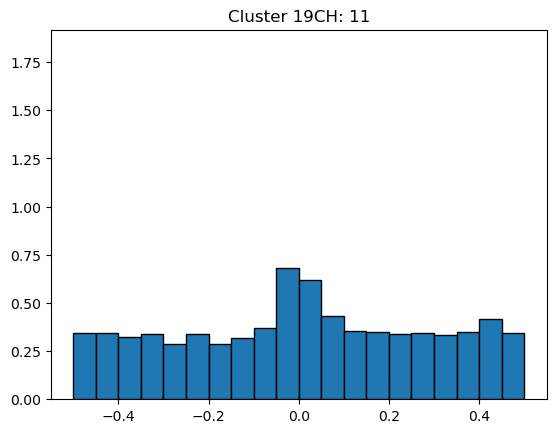

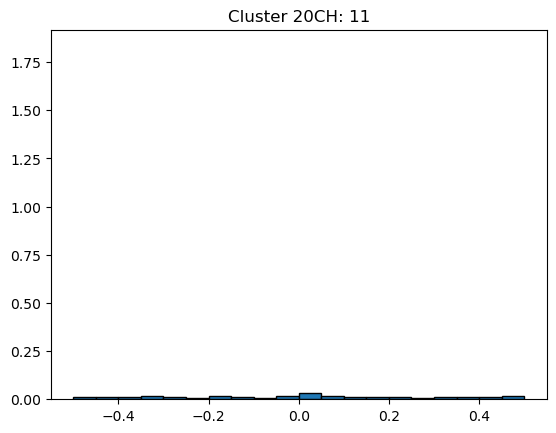

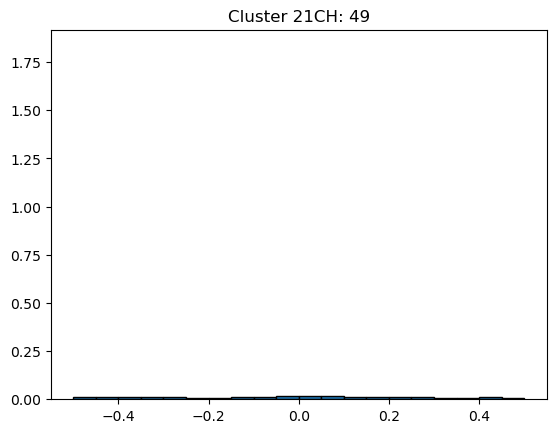

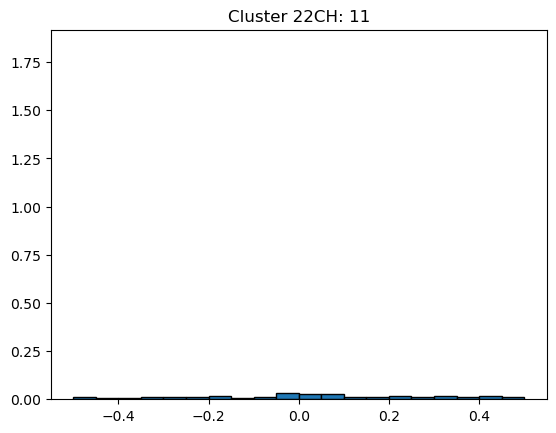

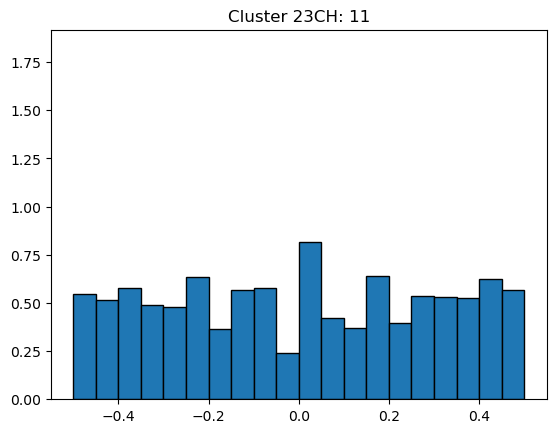

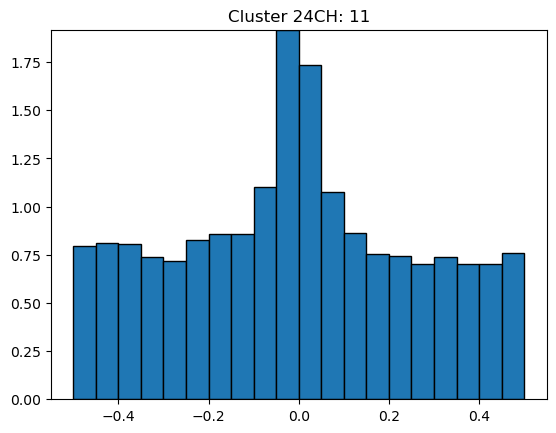

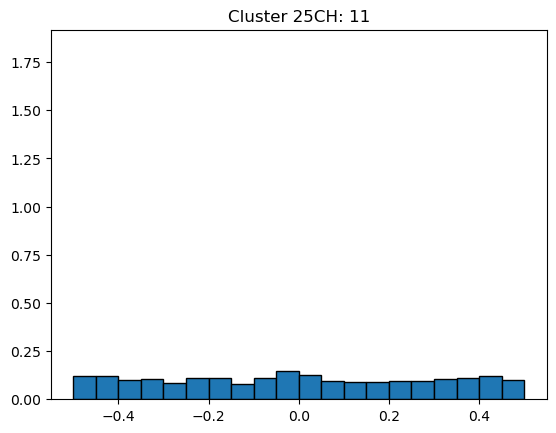

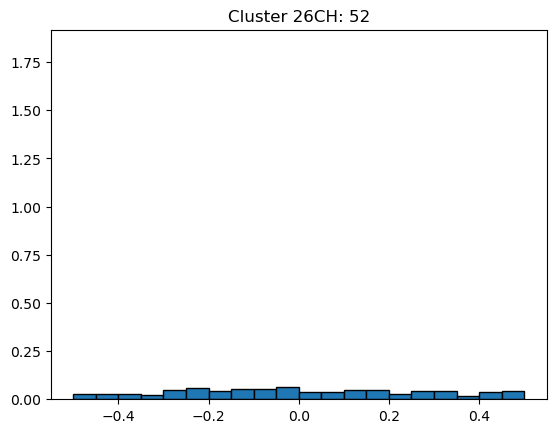

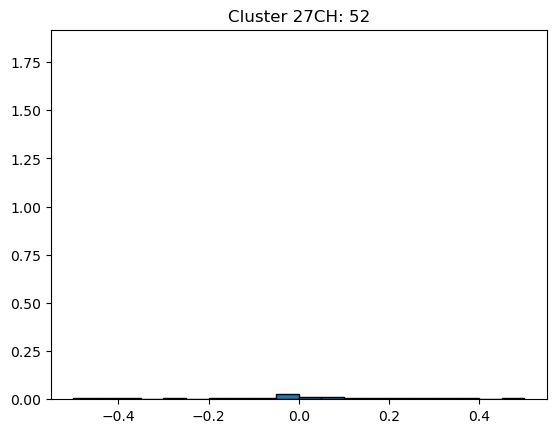

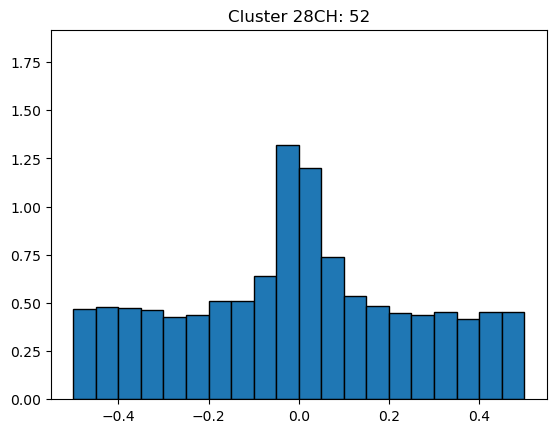

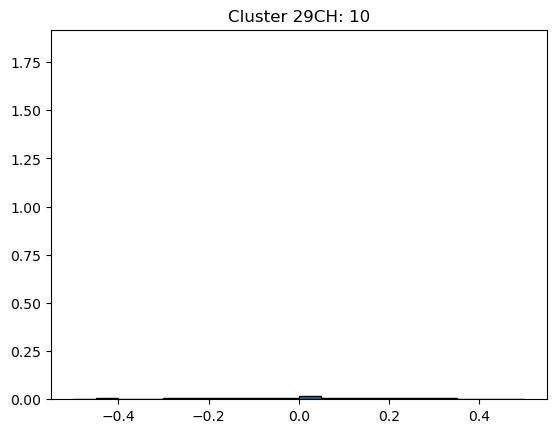

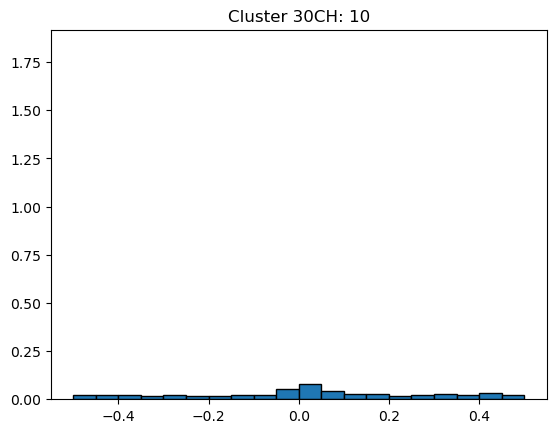

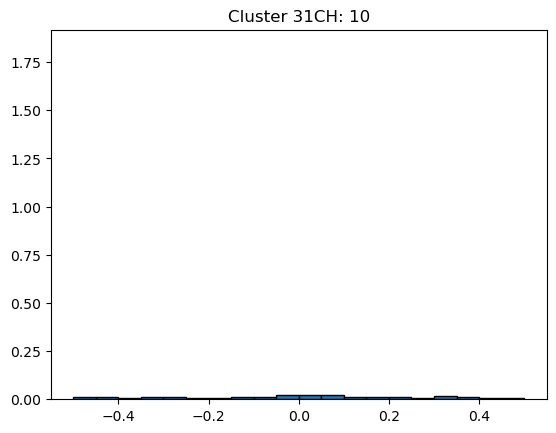

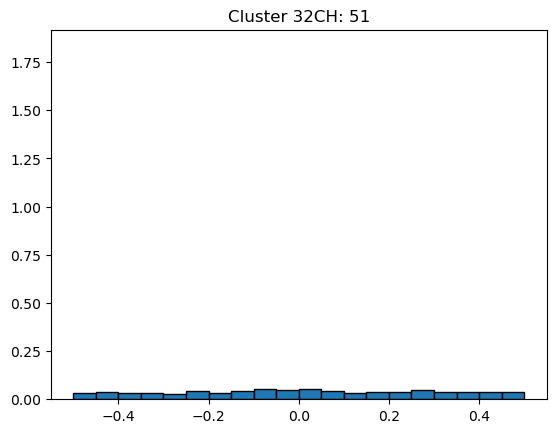

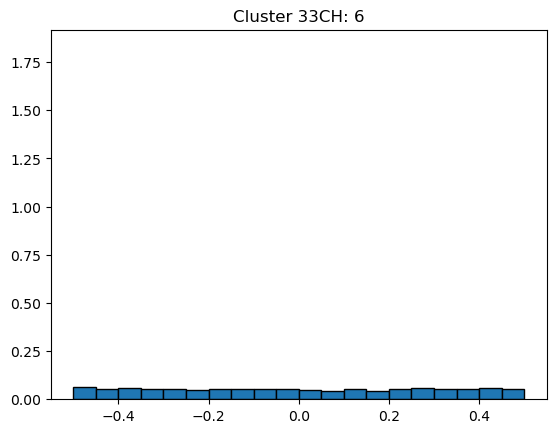

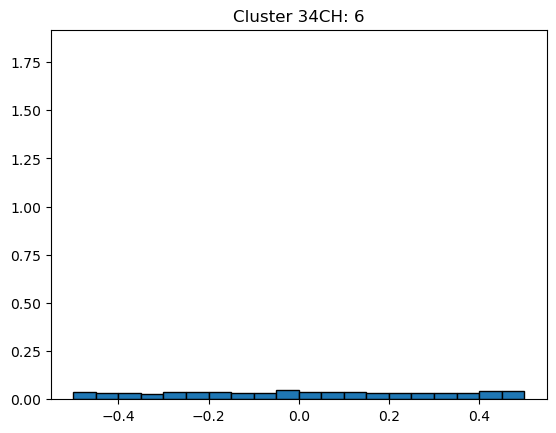

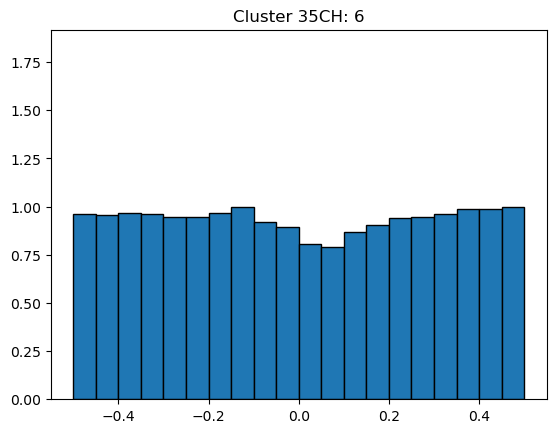

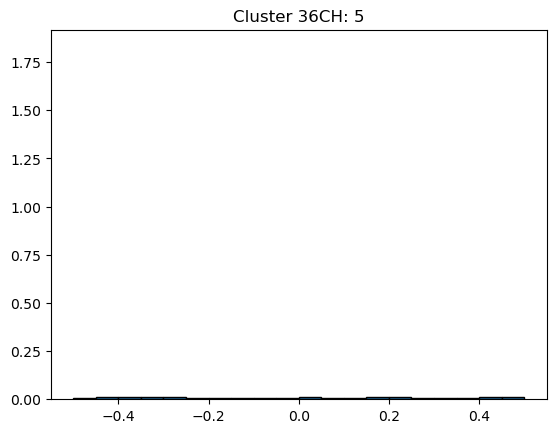

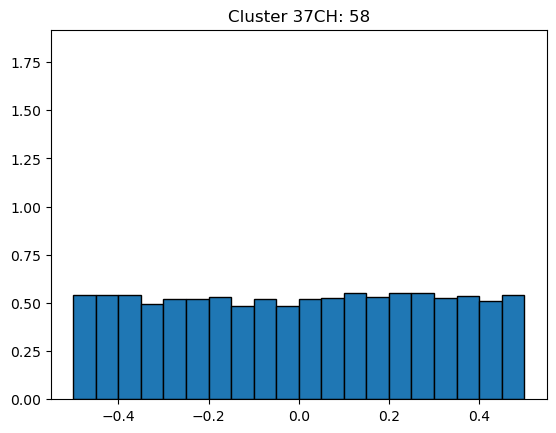

In [276]:
bins=np.linspace(-1*(win/2),1*(win/2),num_bins+1)
for cls, h in enumerate(mean_hist_ses6):
    plt.figure()
    plt.ylim([0,np.max(mean_hist_ses6)])
    plt.bar(bins[:-1], h, width=np.diff(bins), edgecolor="black", align="edge")
    plt.title("Cluster "+str(cls)+"CH: "+str(siteMap[int(spikesByCluster[cls]["site"])]))

## Plotting histograms

/var/folders/cy/wg7pd_p11rg7b4s4wwvgdnvr0000gn/T/ipykernel_60724/3680255413.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


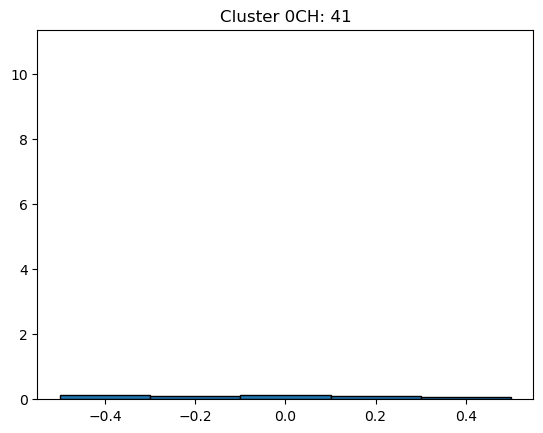

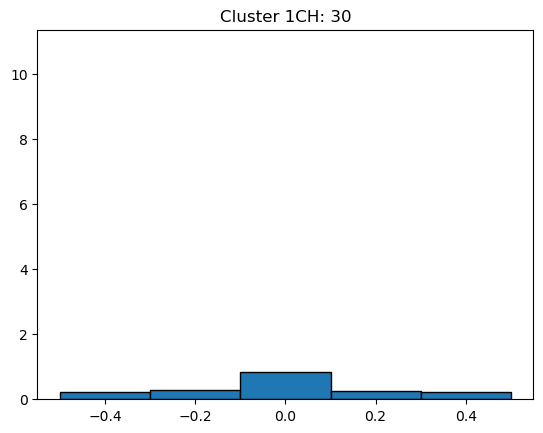

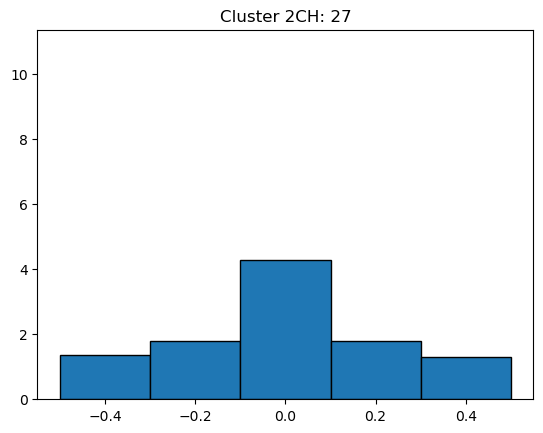

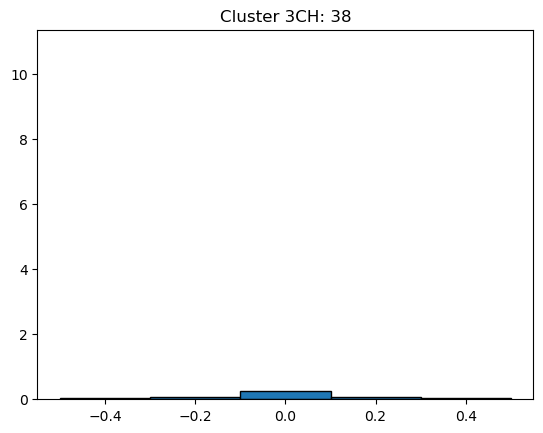

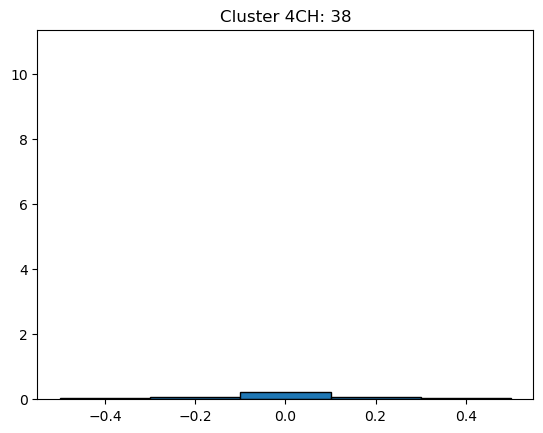

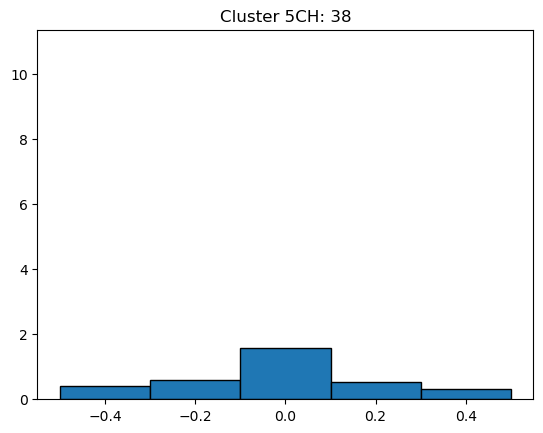

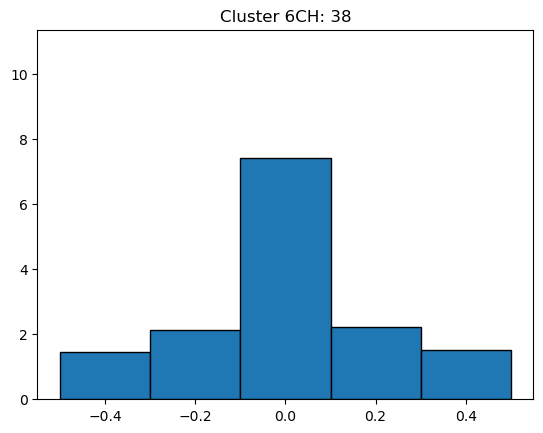

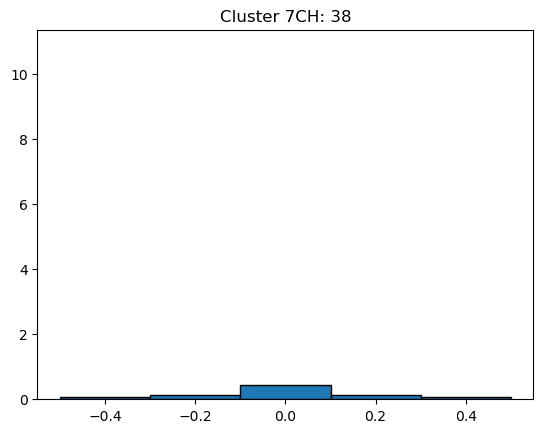

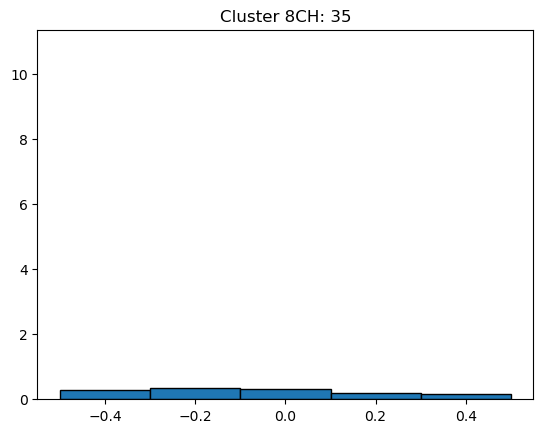

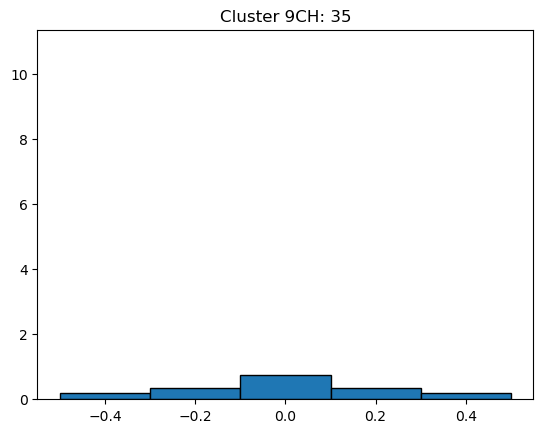

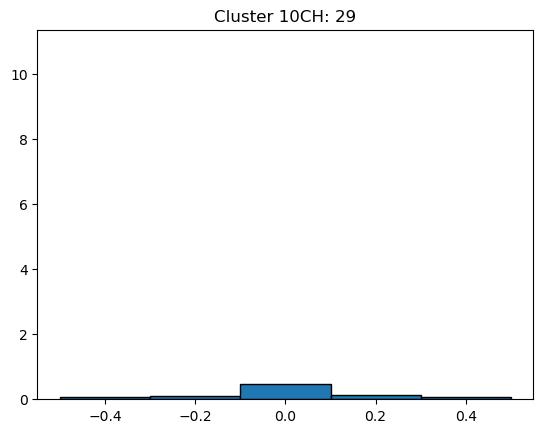

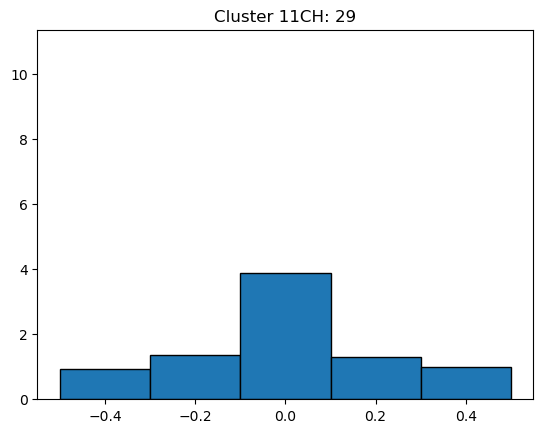

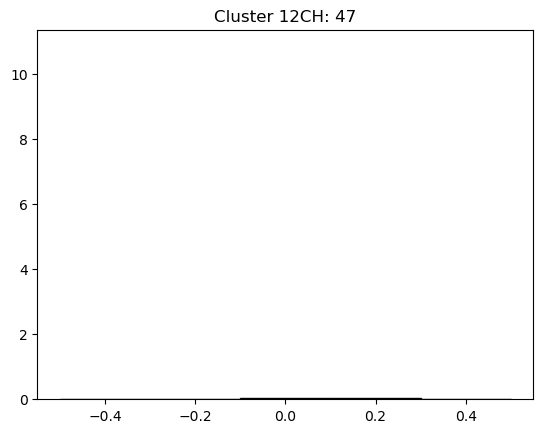

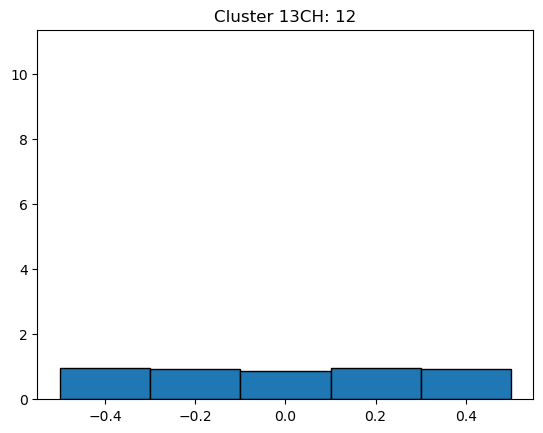

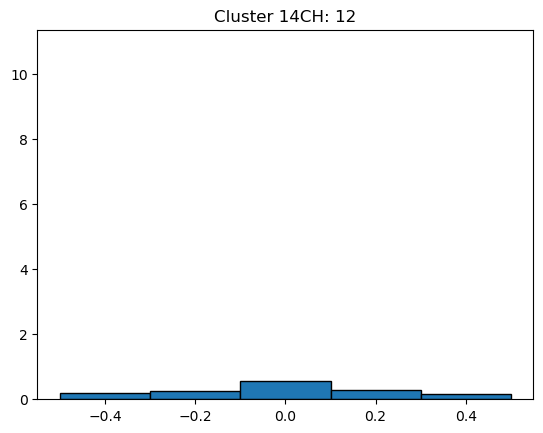

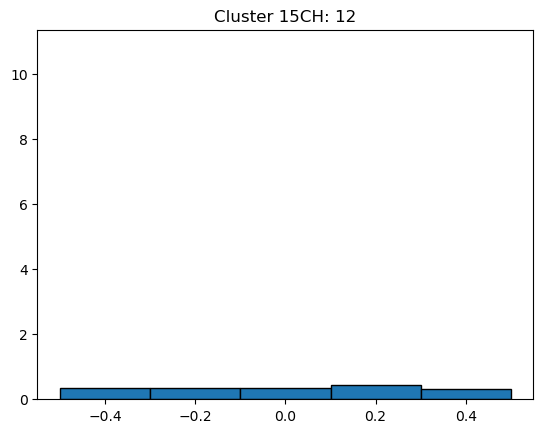

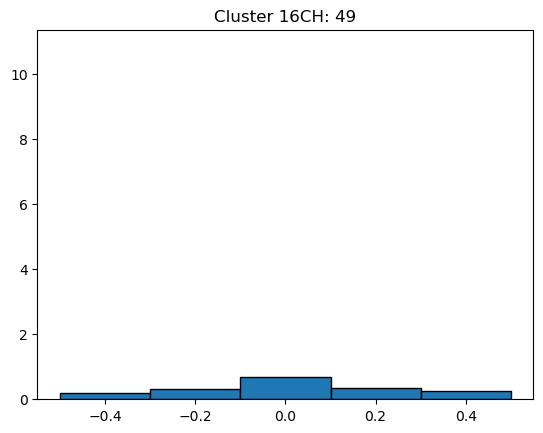

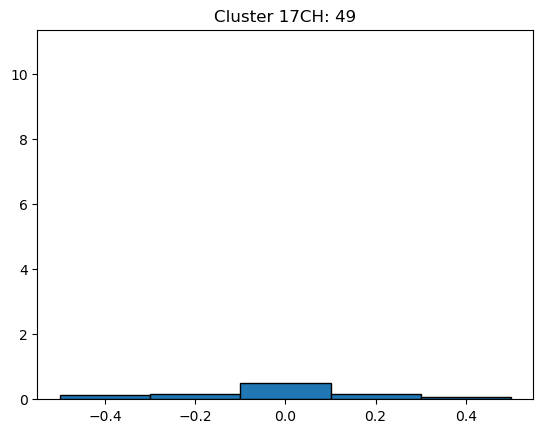

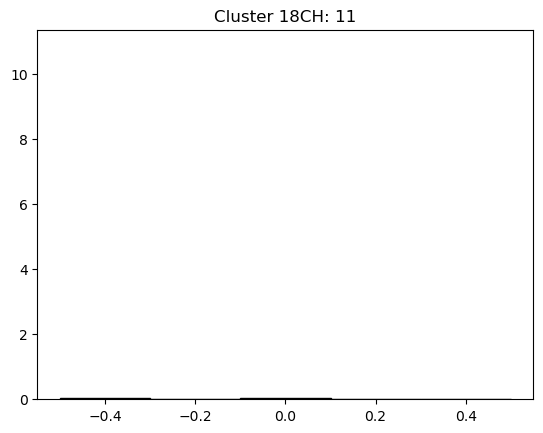

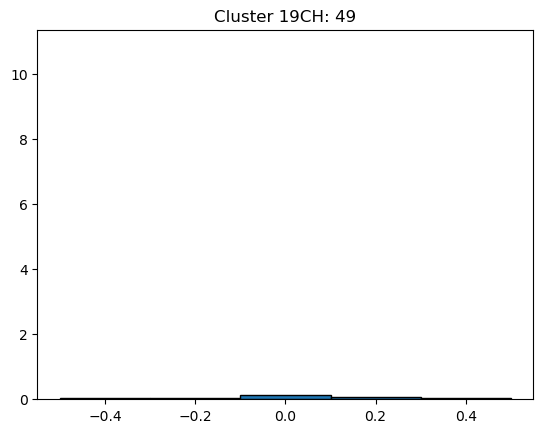

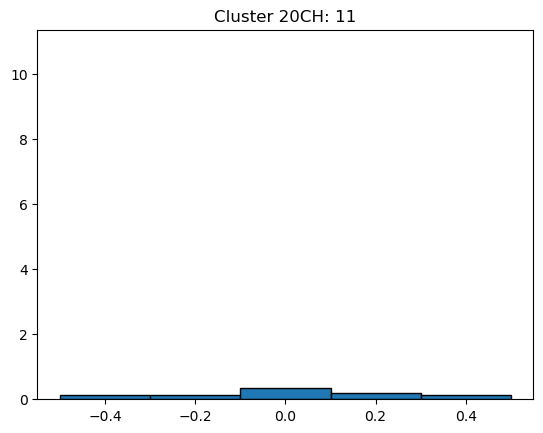

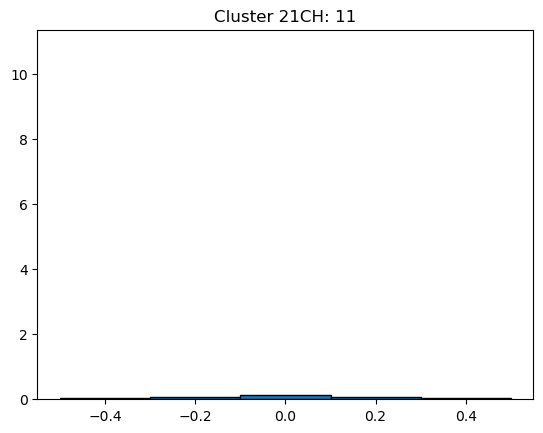

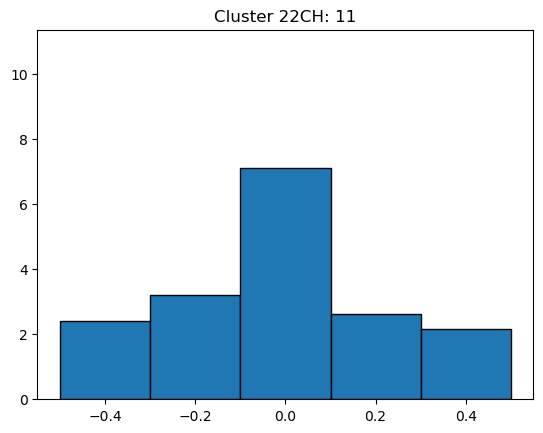

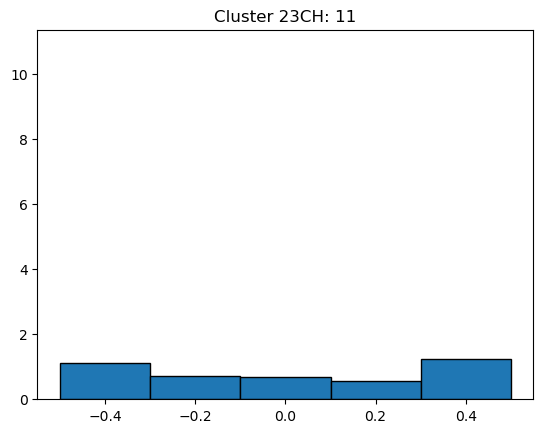

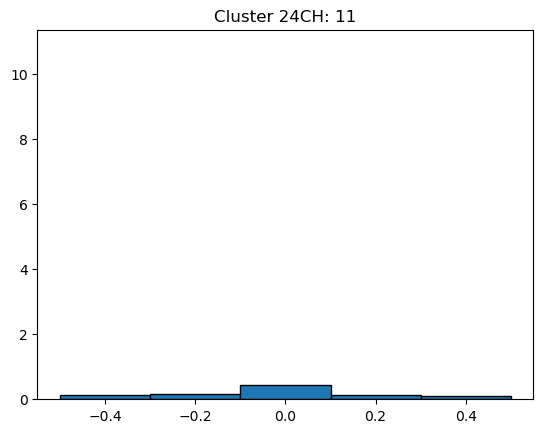

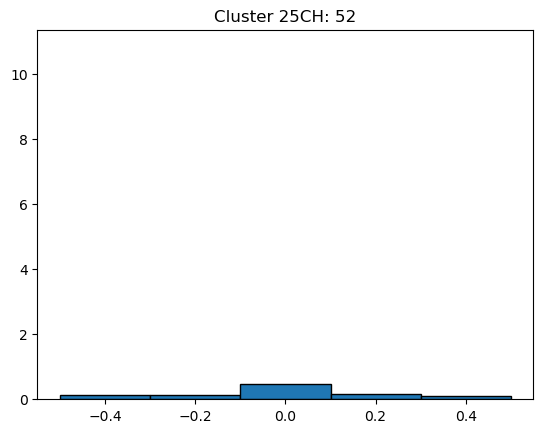

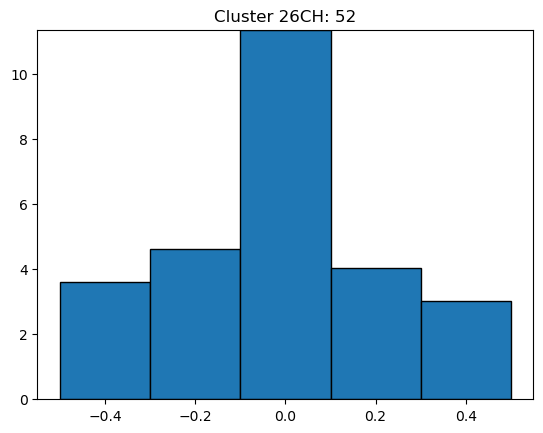

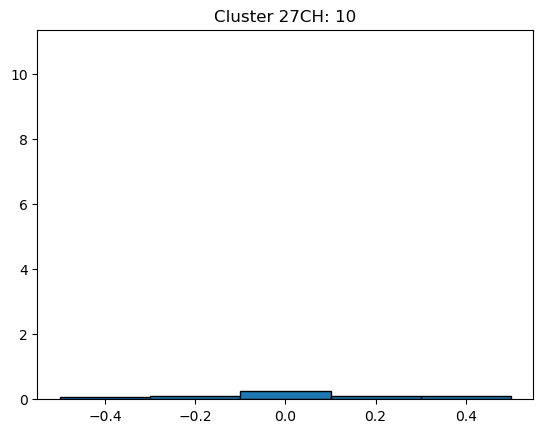

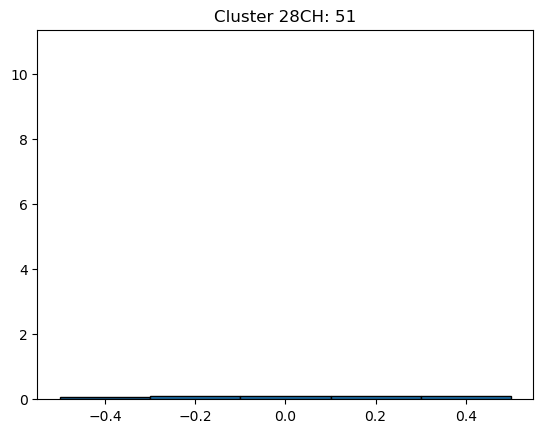

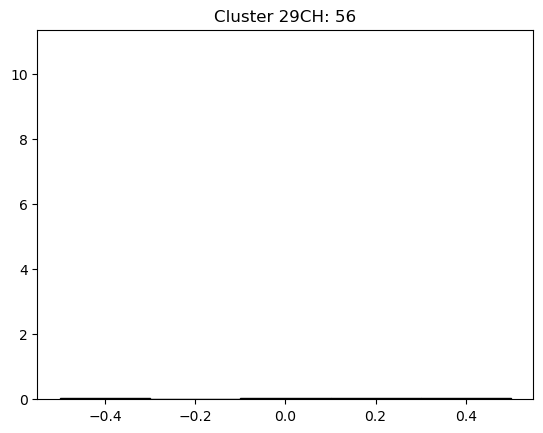

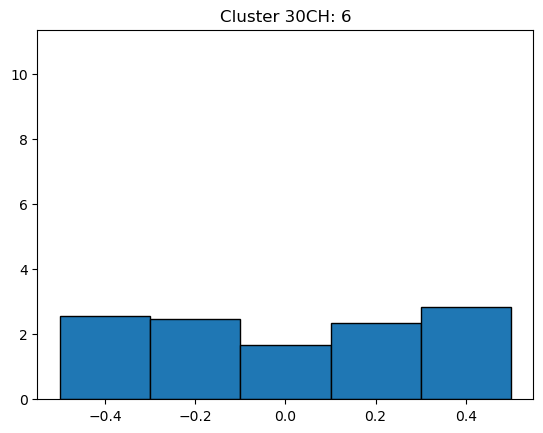

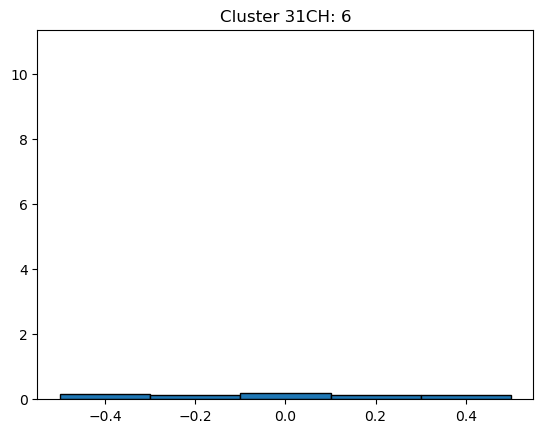

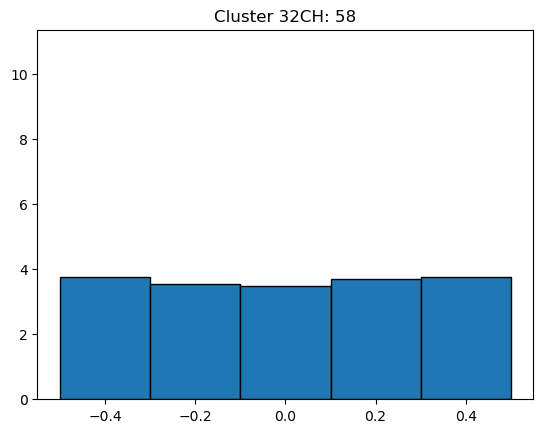

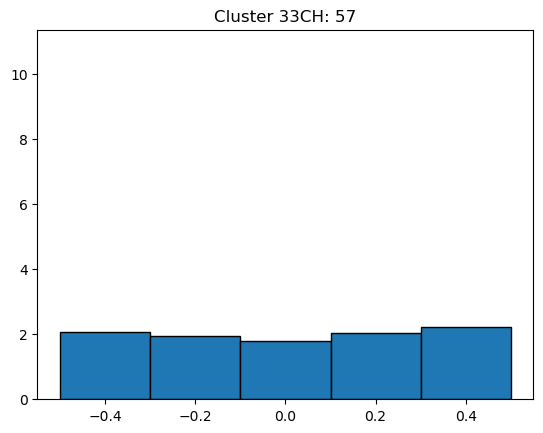

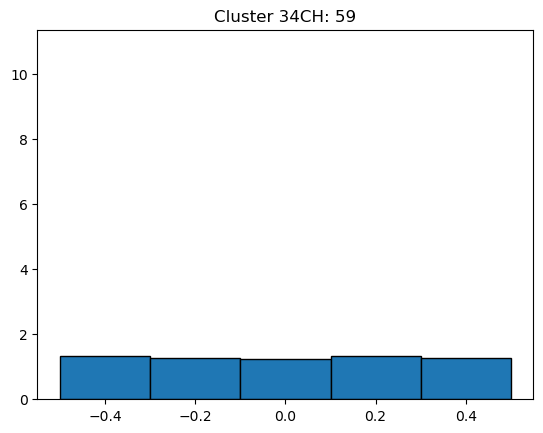

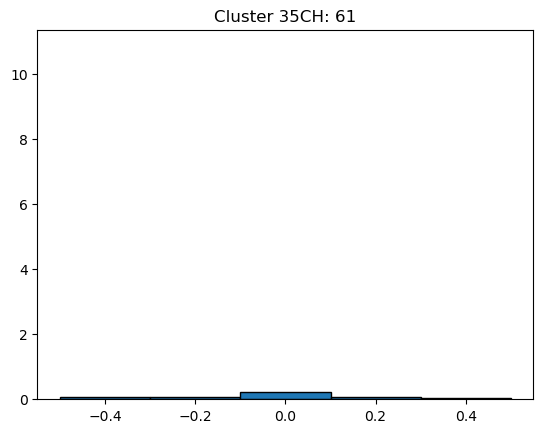

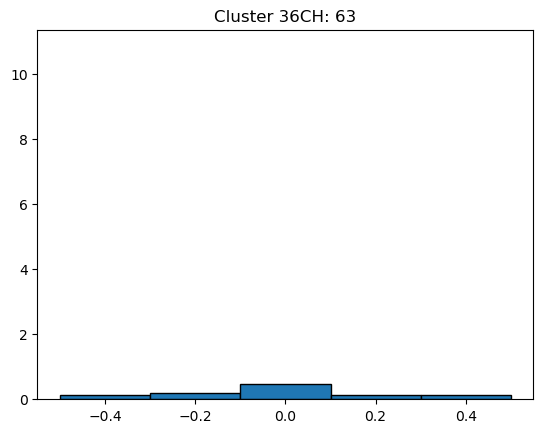

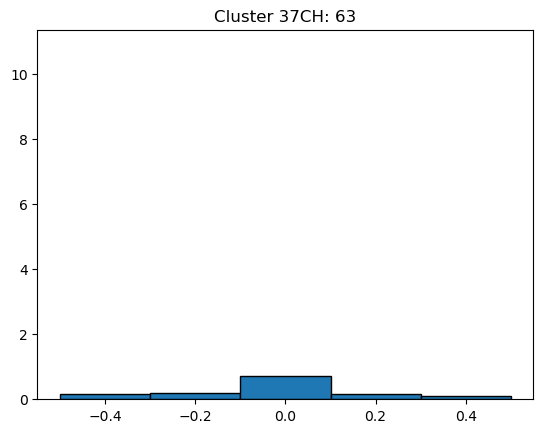

In [240]:
bins=np.linspace(-1*(win/2),1*(win/2),num_bins+1)
for cls, h in enumerate(mean_hist):
    plt.figure()
    plt.ylim([0,np.max(mean_hist)])
    plt.bar(bins[:-1], h, width=np.diff(bins), edgecolor="black", align="edge")
    plt.title("Cluster "+str(cls)+"CH: "+str(siteMap[int(spikesByCluster[cls]["site"])]))

# PCA

In [256]:
s_hist=np.concatenate((standardized_hist_ses6,standardized_hist_ses9))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


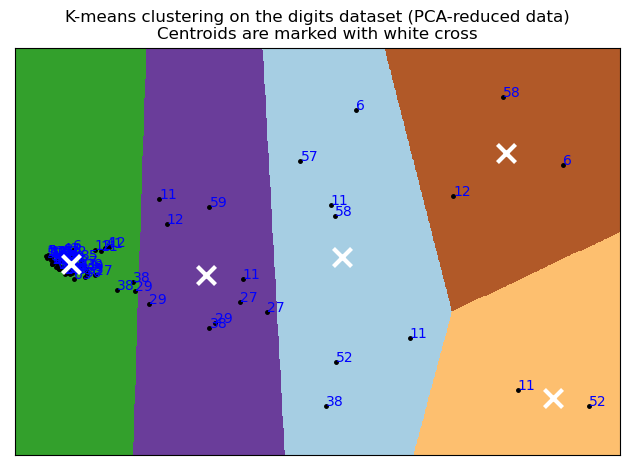

In [302]:
reduced_data=PCA(n_components=2).fit_transform(s_hist)
kmeans = KMeans(init="k-means++", n_clusters=5)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=5)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)

plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)

for cls, vec in enumerate(reduced_data):
    if cls < np.shape(standardized_hist_ses6)[0]:
        Z=kmeans.predict(np.reshape(vec,(1,-1)))
        ch=str(siteMap[int(spikesByCluster_ses6[cls]["site"])])
        plt.text(vec[0],vec[1],ch, fontsize=10, color="b")
    else:
        cls=cls-np.shape(standardized_hist_ses6)[0]
        kmeans.predict(np.reshape(vec,(1,-1)))
        ch=str(siteMap[int(spikesByCluster_ses9[cls]["site"])])
        plt.text(vec[0],vec[1],ch, fontsize=10, color="b")
     
        
        
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
# plt.show()
plt.tight_layout()
plt.savefig("./kmean.png")

In [259]:
pca = PCA(n_components=2)
pca.fit(s_hist)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.94102325 0.04973631]
[37.82003887  8.69477919]


In [296]:
for cls, vec in enumerate(reduced_data):
    if cls < np.shape(standardized_hist_ses6)[0]:
        Z=kmeans.predict(np.reshape(vec,(1,-1)))
        ch=str(siteMap[int(spikesByCluster_ses6[cls]["site"])])
        print("CH:"+ch+"in")
        print(Z)
        print("\n")
    else:
        cls=cls-np.shape(standardized_hist_ses6)[0]
        kmeans.predict(np.reshape(vec,(1,-1)))
        ch=str(siteMap[int(spikesByCluster_ses9[cls]["site"])])
        print("CH:"+ch+"in")
        print(Z)
        print("\n")

CH:42in
[0]


CH:41in
[0]


CH:27in
[0]


CH:27in
[3]


CH:27in
[0]


CH:27in
[0]


CH:38in
[0]


CH:38in
[0]


CH:38in
[0]


CH:38in
[0]


CH:38in
[3]


CH:38in
[0]


CH:38in
[0]


CH:29in
[3]


CH:29in
[0]


CH:12in
[0]


CH:12in
[0]


CH:12in
[1]


CH:49in
[0]


CH:11in
[3]


CH:11in
[0]


CH:49in
[0]


CH:11in
[0]


CH:11in
[2]


CH:11in
[4]


CH:11in
[0]


CH:52in
[0]


CH:52in
[0]


CH:52in
[2]


CH:10in
[0]


CH:10in
[0]


CH:10in
[0]


CH:51in
[0]


CH:6in
[0]


CH:6in
[0]


CH:6in
[1]


CH:5in
[0]


CH:58in
[2]


CH:41in
[2]


CH:30in
[2]


CH:27in
[2]


CH:38in
[2]


CH:38in
[2]


CH:38in
[2]


CH:38in
[2]


CH:38in
[2]


CH:35in
[2]


CH:35in
[2]


CH:29in
[2]


CH:29in
[2]


CH:47in
[2]


CH:12in
[2]


CH:12in
[2]


CH:12in
[2]


CH:49in
[2]


CH:49in
[2]


CH:11in
[2]


CH:49in
[2]


CH:11in
[2]


CH:11in
[2]


CH:11in
[2]


CH:11in
[2]


CH:11in
[2]


CH:52in
[2]


CH:52in
[2]


CH:10in
[2]


CH:51in
[2]


CH:56in
[2]


CH:6in
[2]


CH:6in
[2]


CH:58in
[2]


CH:57in
[2]
